# Plot APEX and ALAMO float data

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from csv import reader
import xarray as xr
# import netCDF4 as nc4
import glob
import gsw
import json
from matplotlib.dates import DateFormatter

In [2]:
## Function to create variable encodings (for NetCDF output file)
# define binary precision 64 bit (double)
array_precision = np.float64
binary_output_dtype = '>f8'
netcdf_fill_value = nc4.default_fillvals['f8']

def create_encoding(G):
    # first create encoding for the data variables 
    dv_encoding = dict()
    for dv in G.data_vars:
        dv_encoding[dv] =  {'zlib':True, \
                            'complevel':5,\
                            'shuffle':True,\
                            '_FillValue':netcdf_fill_value}
    coord_encoding = dict()

    # next encodings for the coordinates
    for coord in G.coords:
        # default encoding: no fill value
        coord_encoding[coord] = {'_FillValue':None}

        if (G[coord].values.dtype == np.int32) or \
           (G[coord].values.dtype == np.int64) :
            coord_encoding[coord]['dtype'] ='int32'

        # this is the key line, time coordinates should be saved as int32s (integer number of nanoseconds)
        if coord == 'time' or coord == 'time_bnds':
            coord_encoding[coord]['dtype'] ='int32'

    # MERGE ENCODINGS DICTIONARIES for coordinates and variables
    encoding = {**dv_encoding, **coord_encoding}

    return encoding

In [3]:
def plot_float_data(float_num, float_model, ymin=-1000, ymax=0, temp_vmin=-0.5, temp_vmax=1.5, salt_vmin=33.2, salt_vmax=34, anomaly=True):
    """
    function to plot temperature and salinity profiles for float data.
    """
    ## open file ------------------------------------------------------
    if float_model=='Alamo':
        output_dir_combined = Path('F:/PhD_chap3/data/OMG_Float_data/OMG_Alamo_Float_Data/Alamo/'+float_num+'/')
        filename_combined = 'ALAMO_' + float_num + '_profiles_binned.nc'
    elif float_model=='Apex':
        output_dir_combined = Path('F:/PhD_chap3/data/OMG_Float_data/OMG_APEX_Float_Data/APEX/'+float_num+'/')
        filename_combined = 'APEX_' + float_num + '_profiles_binned.nc'
    float_data_ds = xr.open_dataset(output_dir_combined / filename_combined)
    
    ## interpolate ----------------------------------------------------
    # first, fill any gaps in CTD profile
    float_data_ds_fill = float_data_ds.interpolate_na(dim='depth_bins')
    # swap dims with dives and date
    float_data_ds_fill = float_data_ds_fill.swap_dims({'dive':'date'})
    
    # interpolation_times = pd.date_range(start=float_data_ds_fill.date.values[0], 
    #                                     end=float_data_ds_fill.date.values[-1], freq='1H').to_numpy()
    # float_data_ds_new = float_data_ds_fill.swap_dims({'dive':'date'})
    # float_data_interp_ds = float_data_ds_new.interp(date=interpolation_times)
    
    ## calculate density
    # float_density_da = gsw.rho_t_exact(float_data_interp_ds.salinity, float_data_interp_ds.temperature, float_data_interp_ds.pressure)
    float_density_da = gsw.rho_t_exact(float_data_ds_fill.salinity, float_data_ds_fill.temperature, float_data_ds_fill.pressure)
    
    ## plot -----------------------------------------------------------
    fig, (ax1,ax2) = plt.subplots(2,1, figsize=[15,7])
    plt.rcParams['font.size'] = '14'
    
    if anomaly == False:   
        levels_temp=np.arange(temp_vmin,temp_vmax,0.05)
        levels_salt=np.arange(salt_vmin,salt_vmax,0.05)
        
        # plot temperature
        float_data_ds_fill.temperature.plot.contourf(y='depth_bins',ax=ax1,levels=levels_temp,cmap="RdYlBu_r",cbar_kwargs={'label': 'Temperature (°C)'});
        ax1.scatter(float_data_ds.date.values,[ymax]*(len(float_data_ds.date.values)), color='k', marker='d', clip_on=False);
        
        # plot salinity
        float_data_ds_fill.salinity.plot.contourf(y='depth_bins',ax=ax2,levels=levels_salt,cbar_kwargs={'label': 'Salinity (PSU)'});
        ax2.scatter(float_data_ds.date.values,[ymax]*(len(float_data_ds.date.values)), color='k', marker='d', clip_on=False)
        
        ## plot density contour (isopycnals)
        # ax1.clabel((float_density_da-1000).plot.contour(ax=ax1,levels=[26.7,27,27.3,27.6,27.9,28.2,29,30,31],colors='k',linewidths=0.8), inline=True, fontsize=12)
        # ax2.clabel((float_density_da-1000).plot.contour(ax=ax2,levels=[26.7,27,27.3,27.6,27.9,28.2,29,30,31],colors='k',linewidths=0.8), inline=True, fontsize=12)
        
    ## plot anomaly
    else:
        levels_temp=np.arange(temp_vmin,temp_vmax,0.01)
        levels_salt=np.arange(salt_vmin,salt_vmax,0.01)
        
        # plot temperature anomaly
        (float_data_interp_ds.temperature-float_data_interp_ds.temperature.sel(depth_bins=slice(ymin,ymax)).mean()).plot.contourf(y='depth_bins',ax=ax1,levels=levels_temp,\
                                                                                                                                  cmap="RdBu_r",cbar_kwargs={'label': 'Temperature (°C)'});
        ax1.scatter(float_data_ds.date.values,[ymax]*(len(float_data_ds.date.values)), color='k', marker='d', clip_on=False);
        
        # plot salinity anomaly
        (float_data_interp_ds.salinity-float_data_interp_ds.salinity.sel(depth_bins=slice(ymin,ymax)).mean()).plot.contourf(y='depth_bins',ax=ax2,levels=levels_salt,\
                                                                                                                            cmap="RdBu_r",cbar_kwargs={'label': 'Salinity (PSU)'});
        ax2.scatter(float_data_ds.date.values,[ymax]*(len(float_data_ds.date.values)), color='k', marker='d', clip_on=False)        
        
        ## plot density contour (isopycnals)
        ax1.clabel((float_density_da-1000).plot.contour(ax=ax1,levels=[27,27.3,27.6,27.9,28.2,29,30,31],colors='k',linewidths=0.8), inline=True, fontsize=12)
        ax2.clabel((float_density_da-1000).plot.contour(ax=ax2,levels=[27,27.3,27.6,27.9,28.2,29,30,31],colors='k',linewidths=0.8), inline=True, fontsize=12)
    
    ## format axis limits and labels
    ax1.set_ylim(ymin,ymax)
    ax2.set_ylim(ymin,ymax)
    
    ax1.set_ylabel("Depth (m)")
    ax1.set_xlabel("")
    ax1.xaxis.set_ticklabels([])
    ax2.set_ylabel("Depth (m)")
    ax2.set_xlabel("")
    
    ## format x axis datetime
    myFmt = DateFormatter('%b-%d-%Y')
    ax2.xaxis.set_major_formatter(myFmt) 
    
    ## set title
    ax1.set_title(str(float_model + ' ' + float_num), pad=10)

## Apex Float data

*// Summary of floats:*

**Melville Bay** <br>
APEX F9444 | 2021-09-19 to 2023-09-03 | *stayed in trough but was stuck on bottom from 9-03 to 9-19* <br>
APEX F9185 | 2020-10-22 to 2021-12-16 | *got pushed out of trough (northbound)*

**Upernavik Trough**<br>
APEX F9186 | 2020-09-13 to 2021-10-30 | *stayed in trough*

**Ummannaq Trough**<br>
APEX F9443 | 2021-09-10 to 2021-10-29 | *stayed in trough*

**Disko Bay**<br>
APEX F9184 | 2020-09-13 to 2020-12-14 | *stayed in trough*


*// Summary of Float Operation (from manual):* <br>

The APEX profiling float automatically descends and activates when it is deployed, performs a self test, which includes an ascent to the surface, and starts a mission by descending to its "Park" depth, which is usually 1000 meters as shown in Figure 1-1. It will drift for typically 10 days at the Park depth and then descend to a deeper depth, the "Profile" depth, which is usually its maximum rated depth of 2000 meters. After reaching the Profile depth, the float will ascend to the surface while acquiring profile data. The trip to the surface from 2000 meters takes approximately 6 hours. When at the surface, a GPS position fix is obtained, and the data and position of the float are transmitted over the Iridium satellite network to a shore based server. While at the surface, the float can accept user commands or download configuration files over the Iridium satellite network to modify its mission configuration parameters which include the Park and Profile depths, the ascent rate and other parameters. In the same manner the float can modify its sample configuration parameters which specify its sampling behavior. After transmitting the information, the float repeats the mission beginning with its descent to the Park depth.

CTD sensor type: 'LGR' - non-pumped type CTD

*// Overview of data structure in Science log csv file*

CTD_P. All rows in the science_log.csv file with the first column label "CTD_P" contain SBE 41CP CTD pressure data. The columns are from left to right: <br>
- Time stamp: UTC (YYYYMMDDTHHMMSS)<br>
- Pressure: Pressure in decibars<br>

CTD_PT. All rows in the science_log.csv file with the first column label "CTD_PT" contain SBE 41CP CTD pressure and temperature data. The columns are from left to right:<br>
- Time stamp: UTC (YYYYMMDDTHHMMSS)
- Pressure: Pressure in decibars
- Temperature: Temperature in degrees Celsius

CTD_PTS. All rows in the science_log.csv file with the first column label "CTD_PTS" contain SBE 41CP CTD data that were recorded when interval sampling. The columns are from left to right:<br>
- Time stamp: UTC (YYYYMMDDTHHMMSS)
- Pressure: Pressure in decibars
- Temperature: Temperature in degrees Celsius
- Salinity: Salinity in PSU

The rows in the science_log.csv file that contain data that were recorded when continuous profiling with an SBE 41CP CTD are the following:

CTD_bins. All rows in the science_log.csv file with the first column label "CTD_bins" contain SBE 41CP CTD bin averaging statistics. The columns are from left to right:
- Time stamp: UTC (YYYYMMDDTHHMMSS)
- Samples: Number of samples recorded during the mission
- Bins: Number of bins recorded during the mission
- Maxpress: Highest pressure in decibars recorded during the mission

CTD_CP. All rows in the science_log.csv file with the first column label "CTD_CP" contain bin averaged SBE 41CP CTD data. The columns are from left to right: <br>
- Time stamp: UTC (YYYYMMDDTHHMMSS)
- Pressure: Bin averaged pressure in decibars
- Temperature: Bin averaged temperature in degrees Celsius
- Salinity: Bin averaged salinity in PSU
- Samples: Number of samples averaged per bin

In [10]:
def read_apex_float(apex_num):
    """
    Function that loops through all *science_log files for a given float
    and extracts CTD profile data ('continuous profiling'), saving it in raw
    and binned netCDF files.
    
    Returns dataset that contains all individual dives (binned every 2m) for the given float.
    """

    ## Set directories for data files and where files will be saved:
    
    # Directory for APEX science_log csv files
    science_logs_list = glob.glob('F:/PhD_chap3/data/OMG_Float_data/OMG_APEX_Float_Data/APEX/'+apex_num+'/Processed/*science_log*')
    
    # NetCDF files for each dive (raw data from csv file)
    output_dir_dives_nc = Path('F:/PhD_chap3/data/OMG_Float_data/OMG_APEX_Float_Data/APEX/'+apex_num+'/Dives_netcdf/')
    output_dir_dives_nc.mkdir(exist_ok = True, parents=True) # make directory if needed
    
    # Mean profiles averaged over depth bins (every 2 meters) for each dive
    output_dir_dives_binned_nc = Path('F:/PhD_chap3/data/OMG_Float_data/OMG_APEX_Float_Data/APEX/'+apex_num+'/Dives_binned_netcdf/')
    output_dir_dives_binned_nc.mkdir(exist_ok = True, parents=True) # make directory if needed
    
    # Individual binned dives combined into one netCDF for each float
    output_dir_combined = Path('F:/PhD_chap3/data/OMG_Float_data/OMG_APEX_Float_Data/APEX/'+apex_num+'/')
    
    ## Loop through all data files (for each dive) and save individal and binned netCDF files
    
    for i in range(len(science_logs_list)): 
        dive_num = np.array([int(science_logs_list[i].split('Dive_')[1][:3])])
        data_lines = []
        gps = []
        
        if dive_num > 0: # dive '0' is diagnostic
            with open(science_logs_list[i], 'r') as read_obj:
                csv_reader = reader(read_obj)
            
                # Iterate over each row in the csv using reader object
                for row in csv_reader: # row variable is a list that represents a row in csv
                    if row[0] ==  'LGR_CP_PTSCI': # CP refers to continuous profiling
                        data_lines.append(row)
                    if row[0] == 'GPS': # extract lat/lon fixes
                        gps.append(row[2:4])
                read_obj.close()
            
                if len(data_lines) > 5: # there are some cases where only a few observations were made in `CP` at the seafloor...
                    # ...(we want to discard this dive since it wasn't complete and the float was stuck)
                    # make list a data array
                    data_array = np.array(data_lines)     
                    gps_array  = np.array(gps, dtype='float')
                    
                    # pull out each variable from data array
                    pressure     = np.array(data_array[:,2], dtype='float')
                    temperature  = np.array(data_array[:,3], dtype='float')
                    salinity     = np.array(data_array[:,4], dtype='float')
                    conductivity = np.array(data_array[:,5], dtype='float')
                    
                    # extract first time stamp which provides the start time of the profile (= start of ascent mission)
                    start_time = data_array[:,1][0] # first time recorded for 'CP'
                    start_time_dt = np.datetime64(start_time[0:4]+'-'+start_time[4:6]+'-'+start_time[6:11]+':'+start_time[11:13]+':'+start_time[13:]) # datetime format
                    
                    # convert pressure to depth
                    depth = gsw.z_from_p(pressure, lat=75.5)
                    
                    # create Dataset for dive and save as netCDF
                    dive_ds = xr.Dataset()
                    dive_ds['pressure']           = xr.DataArray([pressure], dims=['dive','depth'], coords={'dive':dive_num, 'depth':depth, 'date':('dive', [start_time_dt])})
                    dive_ds['pressure'].attrs     = {'standard_name':'pressure', 'units': 'dBar'}
                    dive_ds['temperature']        = xr.DataArray([temperature], dims=['dive','depth'], coords={'dive':dive_num, 'depth':depth, 'date':('dive', [start_time_dt])})
                    dive_ds['temperature'].attrs  = {'standard_name':'temperature', 'units': 'degC', 'comments':'In-situ temperature (ITS-90)'}
                    dive_ds['salinity']           = xr.DataArray([salinity], dims=['dive','depth'], coords={'dive':dive_num, 'depth':depth, 'date':('dive', [start_time_dt])})
                    dive_ds['salinity'].attrs     = {'standard_name':'practical_salinity', 'units': 'psu'}
                    dive_ds['conductivity']       = xr.DataArray([conductivity], dims=['dive','depth'], coords={'dive':dive_num, 'depth':depth, 'date':('dive', [start_time_dt])})
                    dive_ds['conductivity'].attrs = {'standard_name':'conductivity'}
                    
                    # add lat/lon nondimensional coordinates
                        # the float will try to take three gps fixes for each dive log:
                        # 1) when starting the mission at the surface
                        # 2) after transmitting/uploading data and right before diving
                        # 3) reaching the surface after completing the mission (dive)
                        # I am only pulling the last fix since it is closest in time to when the profile actually occured (during the ascent)
                    if len(gps) > 0:
                        gps_final = gps_array[-1]
                        dive_ds = dive_ds.assign_coords({'lat':('dive', [gps_final[0]])})
                        dive_ds = dive_ds.assign_coords({'lon':('dive', [gps_final[1]])})
                    else: # sometimes the float wasn't able to get a GPS fix due to conditions (e.g., ice)
                        dive_ds = dive_ds.assign_coords({'lat':('dive', [np.nan])})
                        dive_ds = dive_ds.assign_coords({'lon':('dive', [np.nan])})
                        
                    # add metadata
                    dive_ds['dive'].attrs  = {'comments':'Dive number'}
                    dive_ds['depth'].attrs = {'units': 'meters','comments':'Depth in meters calculated from pressure'}
                    dive_ds['date'].attrs  = {'comments':'Indicates start time of profile'}
                    dive_ds['lat'].attrs   = {'units': 'degrees','comments':'Latitude of profile'}
                    dive_ds['lon'].attrs   = {'units': 'degrees','comments':'Longitude of profile'}
                    
                    # save netcdf to disk      
                    filename_tmp = science_logs_list[i].split('\\')[1][:39] + '.nc'                                         
                    dive_ds.to_netcdf(output_dir_dives_nc / filename_tmp)
                    dive_ds.close()
                    
                    # now bin and average data every 2 meters and save new netcdf
                    bins = np.arange(-1202,2,2) # create predetermined bins from 0 to 1200 meters
                    binned_ds = dive_ds.groupby_bins('depth',bins,labels=bins[1:]).mean() # group and average data across each bin
                    # binned_ds.coords['depth_bins'] = xr.DataArray(bins[1:], dims=['depth_bins']) # reassign coordinate values to be bins
                    
                    # copy over variable attributes from original dataset to binned dataset
                    binned_ds.pressure.attrs     = dive_ds.pressure.attrs
                    binned_ds.temperature.attrs  = dive_ds.temperature.attrs
                    binned_ds.salinity.attrs     = dive_ds.salinity.attrs
                    binned_ds.conductivity.attrs = dive_ds.conductivity.attrs
                    
                    filename_binned = science_logs_list[i].split('\\')[1][:39] + '_binned.nc'
                    binned_ds.to_netcdf(output_dir_dives_binned_nc / filename_binned)
                    binned_ds.close()
                
                else: print('dive',dive_num[0], ' has no continuous profiling data')
            
    # Load all netCDF DataArrays and create combined Dataset for float
    files = list(output_dir_dives_binned_nc.glob('*nc'))

    all_dives_float_ds = xr.open_mfdataset(files,combine='nested', \
                                           concat_dim='dive', parallel=True,\
                                           data_vars='all', coords='all')
    
    # add metadata
    all_dives_float_ds.attrs['Float_type'] = 'APEX'
    all_dives_float_ds.attrs['Float_number'] = apex_num
    all_dives_float_ds.depth_bins.attrs = {'units': 'meters','comments':'Binned depths used for mean profiles'}
    
    # save new, combined dataset
    filename_combined = 'APEX_' + apex_num + '_profiles_binned.nc'
    # create encoding using function defined above
    new_encoding = create_encoding(all_dives_float_ds)
    all_dives_float_ds.to_netcdf(output_dir_combined / filename_combined, encoding=new_encoding)
    all_dives_float_ds.close()
    
    return all_dives_float_ds

### APEX Float F9185 - *Melville Bay*

Need to modify filenames to be consistent with other files. <br>
*Example:* <br>
    original filename: "031-1720.000.20200814T140154.test.txt" <br>
    modified filename: "OMG_APEX_F9185_Dive_000.20200814T140154.test.txt" <br>

In [ ]:
import os
## update filenames
float_dir = '../../data/OMG_Float_data/OMG_APEX_Float_Data/APEX/F9185/Processed/'
for file in os.listdir(float_dir):
    filename = float_dir + file
    new_filename = float_dir + "OMG_APEX_F9185_Dive_" + file[9:]
    os.rename(filename, new_filename)

In [78]:
float_num   = 'F9185'
float_model = 'Apex'

In [36]:
# run function
F9185_data_ds = read_apex_float(float_num)

dive 1  has no continuous profiling data
dive 2  has no continuous profiling data
dive 3  has no continuous profiling data
dive 4  has no continuous profiling data
dive 5  has no continuous profiling data
dive 6  has no continuous profiling data
dive 7  has no continuous profiling data
dive 8  has no continuous profiling data
dive 9  has no continuous profiling data
dive 10  has no continuous profiling data
dive 11  has no continuous profiling data
dive 12  has no continuous profiling data
dive 13  has no continuous profiling data
dive 14  has no continuous profiling data
dive 15  has no continuous profiling data
dive 16  has no continuous profiling data
dive 17  has no continuous profiling data
dive 18  has no continuous profiling data
dive 19  has no continuous profiling data
dive 20  has no continuous profiling data
dive 21  has no continuous profiling data
dive 22  has no continuous profiling data
dive 23  has no continuous profiling data
dive 24  has no continuous profiling data
d

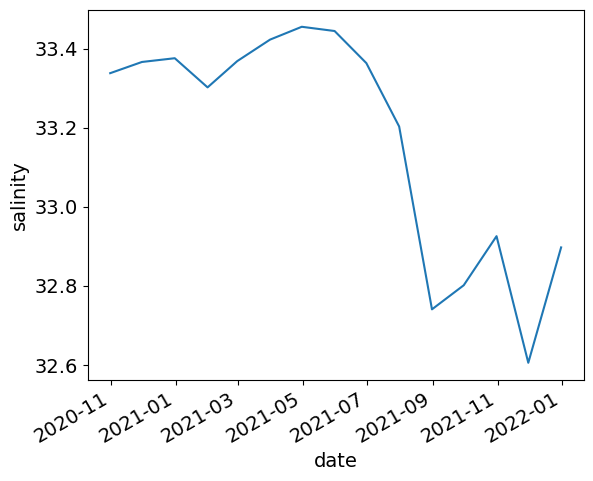

In [67]:
F9185_data_ds.sel(depth_bins=slice(-100,0)).salinity.mean(dim='depth_bins').swap_dims({"dive":"date"}).resample(date='1M').mean("date").plot()

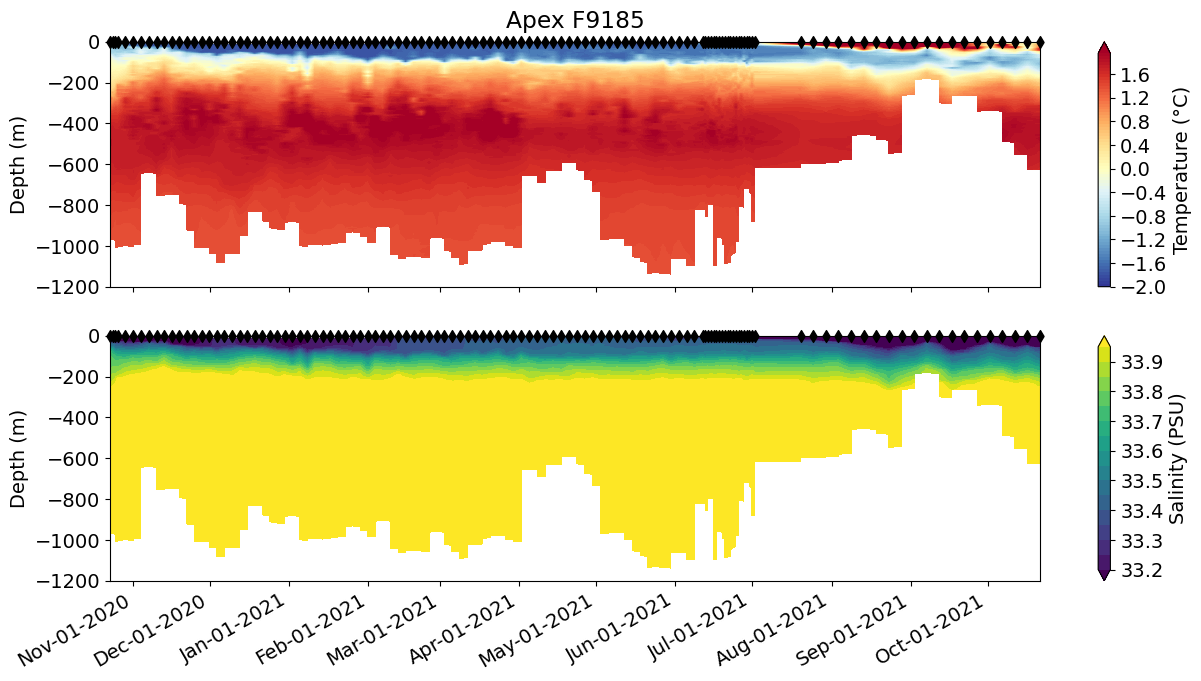

In [175]:
plot_float_data(float_num, float_model, ymin=-1200, ymax=0, temp_vmin=-2, temp_vmax=2, salt_vmin=33.2, salt_vmax=34, anomaly=False)

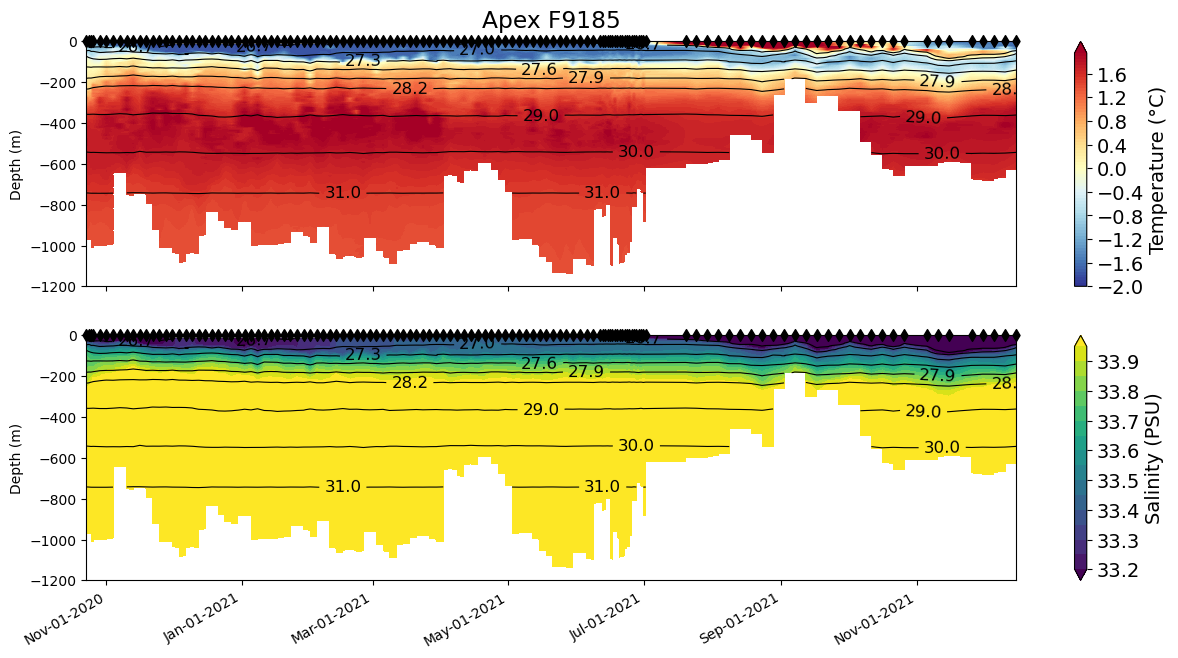

In [37]:
plot_float_data(float_num, float_model, ymin=-1200, ymax=0, temp_vmin=-2, temp_vmax=2, salt_vmin=33.2, salt_vmax=34, anomaly=False)

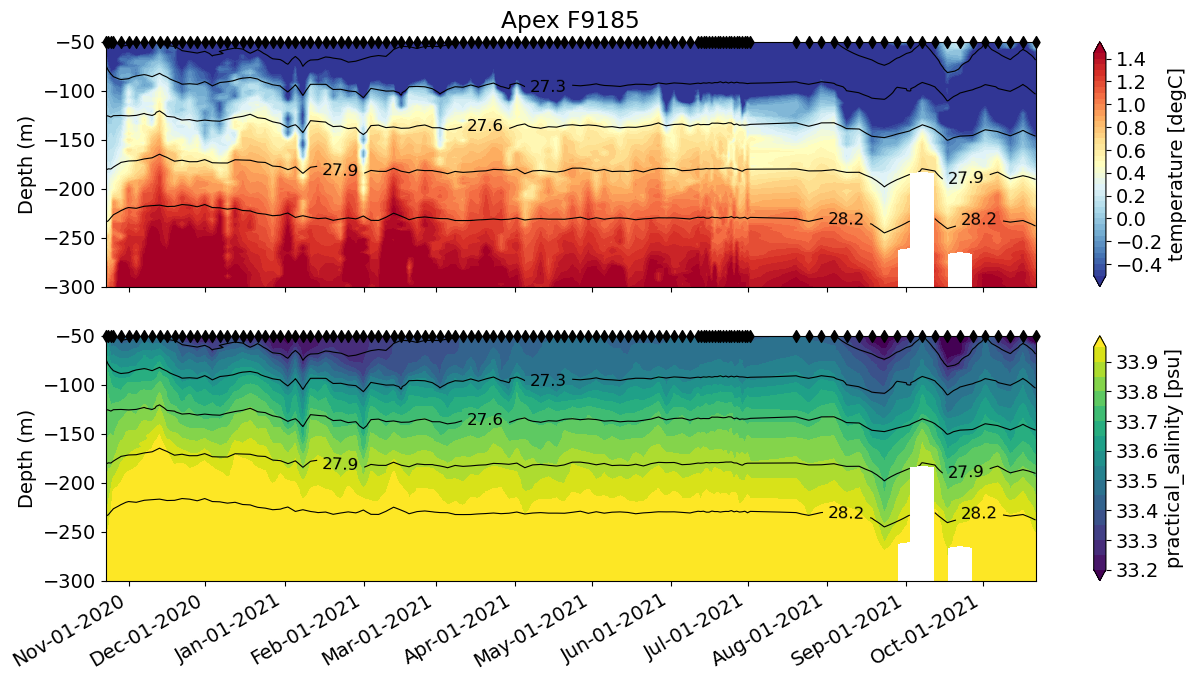

In [140]:
plot_float_data(float_num, float_model, ymin=-300, ymax=-50, temp_vmin=-0.5, temp_vmax=1.5, salt_vmin=33.2, salt_vmax=34, anomaly=False)

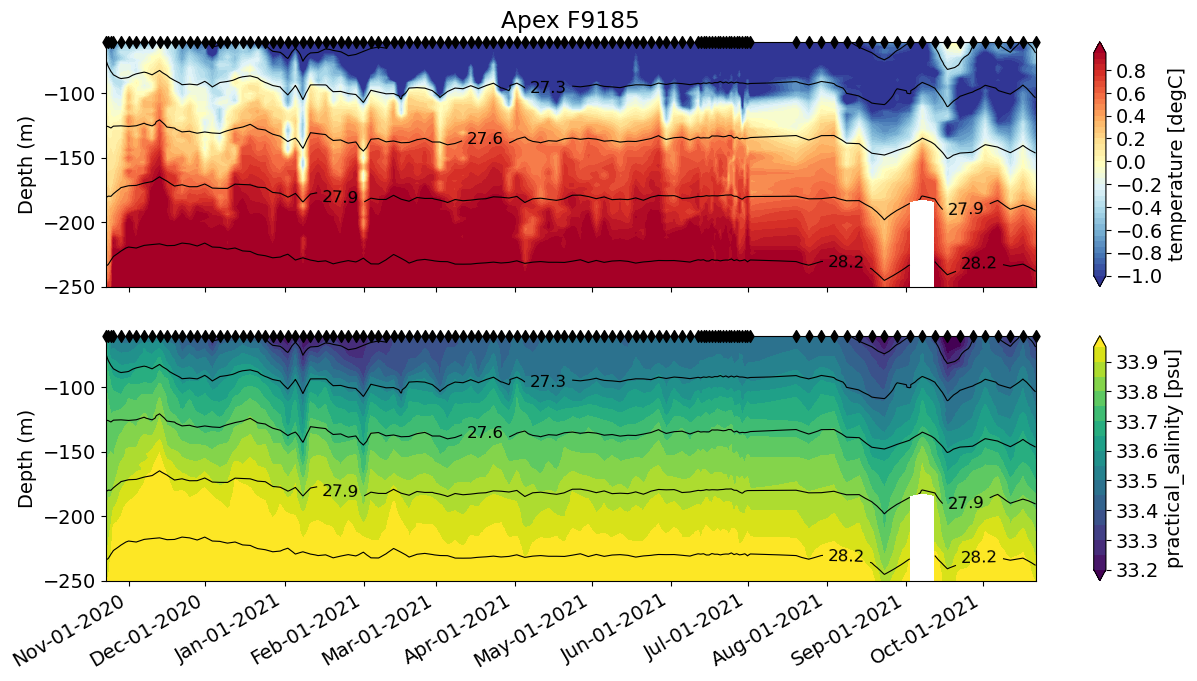

In [141]:
plot_float_data(float_num, float_model, ymin=-250, ymax=-60, temp_vmin=-1, temp_vmax=1, salt_vmin=33.2, salt_vmax=34, anomaly=False)

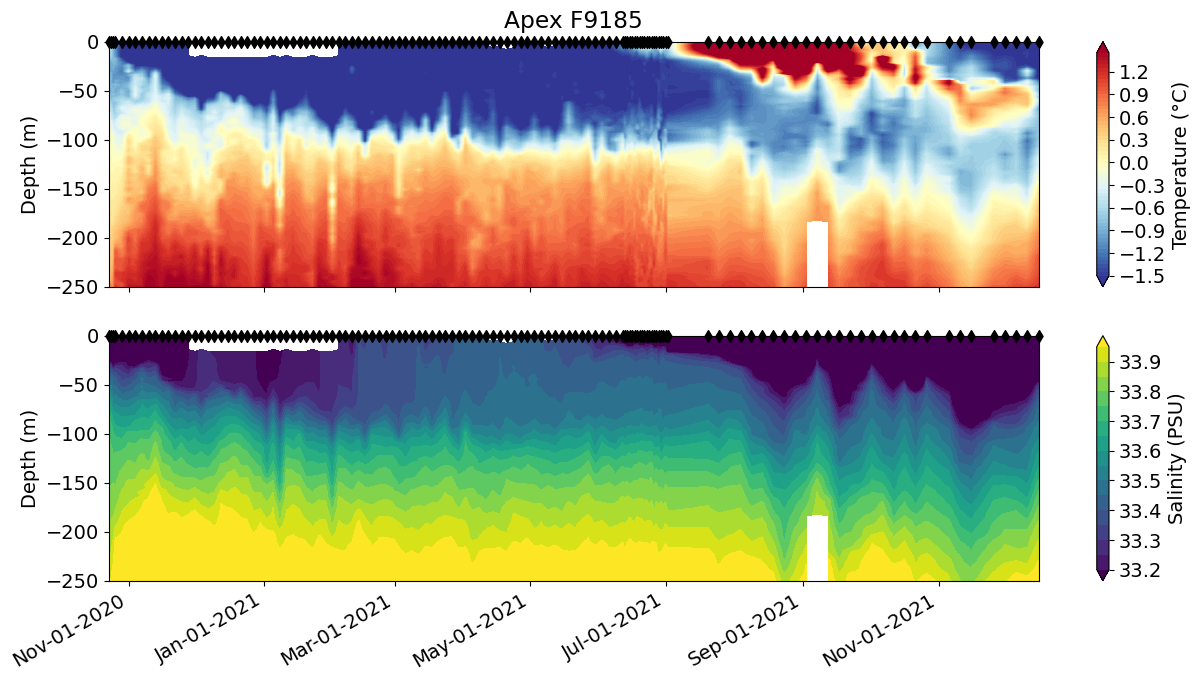

In [79]:
plot_float_data(float_num, float_model, ymin=-250, ymax=0, temp_vmin=-1.5, temp_vmax=1.5, salt_vmin=33.2, salt_vmax=34, anomaly=False)

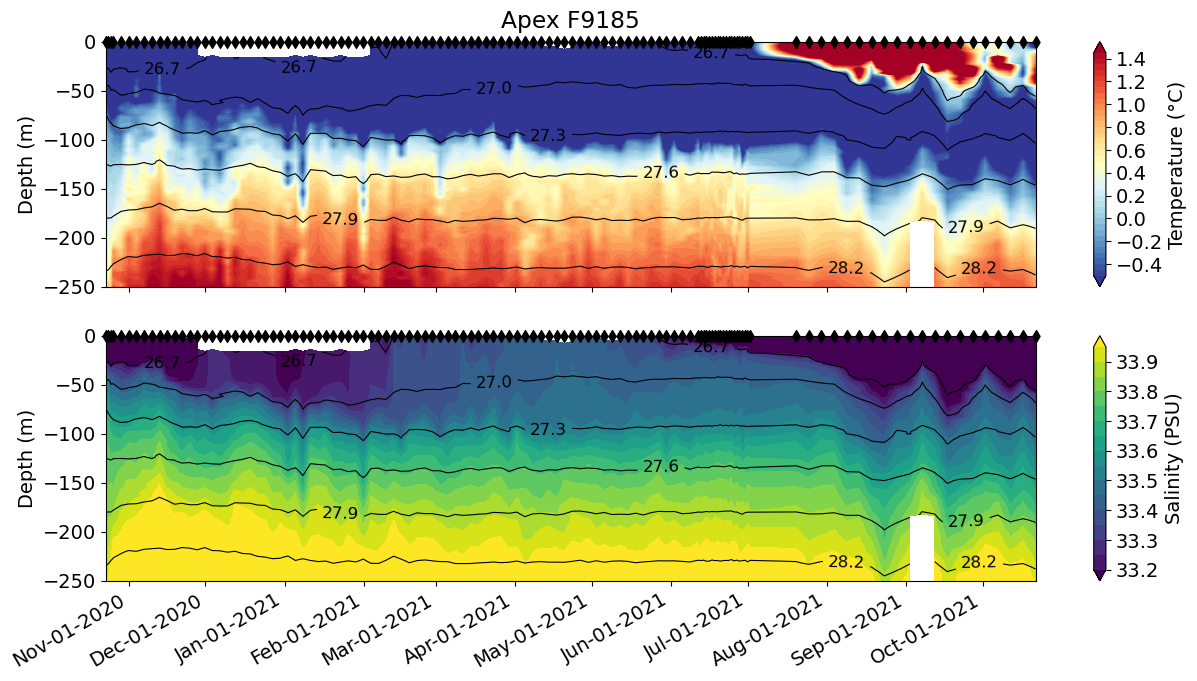

In [181]:
plot_float_data(float_num, float_model, ymin=-250, ymax=0, temp_vmin=-0.5, temp_vmax=1.5, salt_vmin=33.2, salt_vmax=34, anomaly=False)

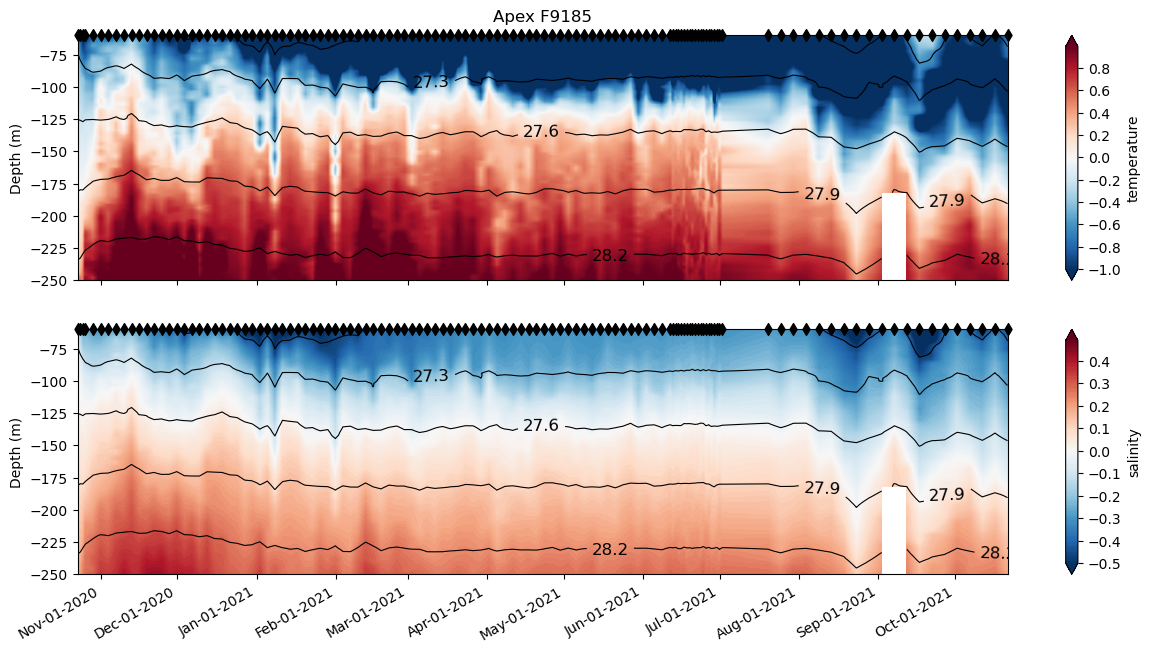

In [99]:
plot_float_data(float_num, float_model, ymin=-250, ymax=-60, temp_vmin=-1, temp_vmax=1, salt_vmin=-0.5, salt_vmax=0.5, anomaly=True)

### APEX Float F9444 - *Melville Bay*

In [5]:
import os
## update filenames
float_dir = 'F:/PhD_chap3/data/OMG_Float_Data/OMG_APEX_Float_Data/APEX/F9444/Processed/'
for file in os.listdir(float_dir):
    filename = float_dir + file
    new_filename = float_dir + "OMG_APEX_F9444_Dive_" + file[9:]
    os.rename(filename, new_filename)

In [5]:
float_num   = 'F9444'
float_model = 'Apex'

In [11]:
# run function
F9444_data_ds = read_apex_float(float_num)

dive 1  has no continuous profiling data
dive 2  has no continuous profiling data
dive 3  has no continuous profiling data
dive 4  has no continuous profiling data
dive 5  has no continuous profiling data
dive 6  has no continuous profiling data
dive 7  has no continuous profiling data
dive 8  has no continuous profiling data
dive 9  has no continuous profiling data
dive 10  has no continuous profiling data
dive 11  has no continuous profiling data
dive 12  has no continuous profiling data
dive 13  has no continuous profiling data


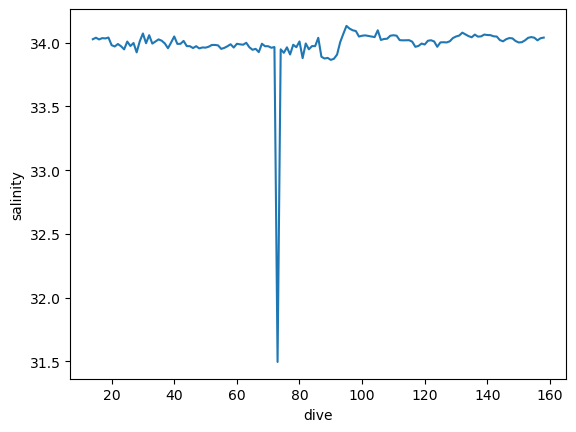

In [10]:
F9444_data_ds.sel(depth_bins=slice(-240,-220)).salinity.mean(dim='depth_bins').plot()

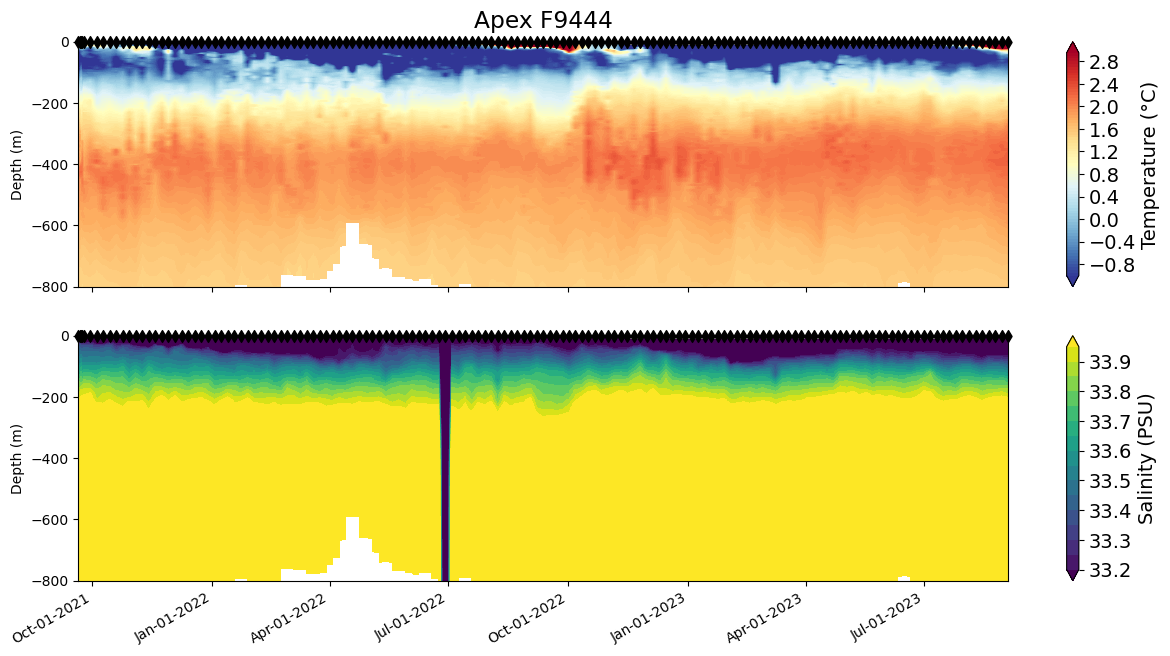

In [12]:
plot_float_data(float_num, float_model, ymin=-800, ymax=0, temp_vmin=-1, temp_vmax=3, salt_vmin=33.2, salt_vmax=34, anomaly=False)

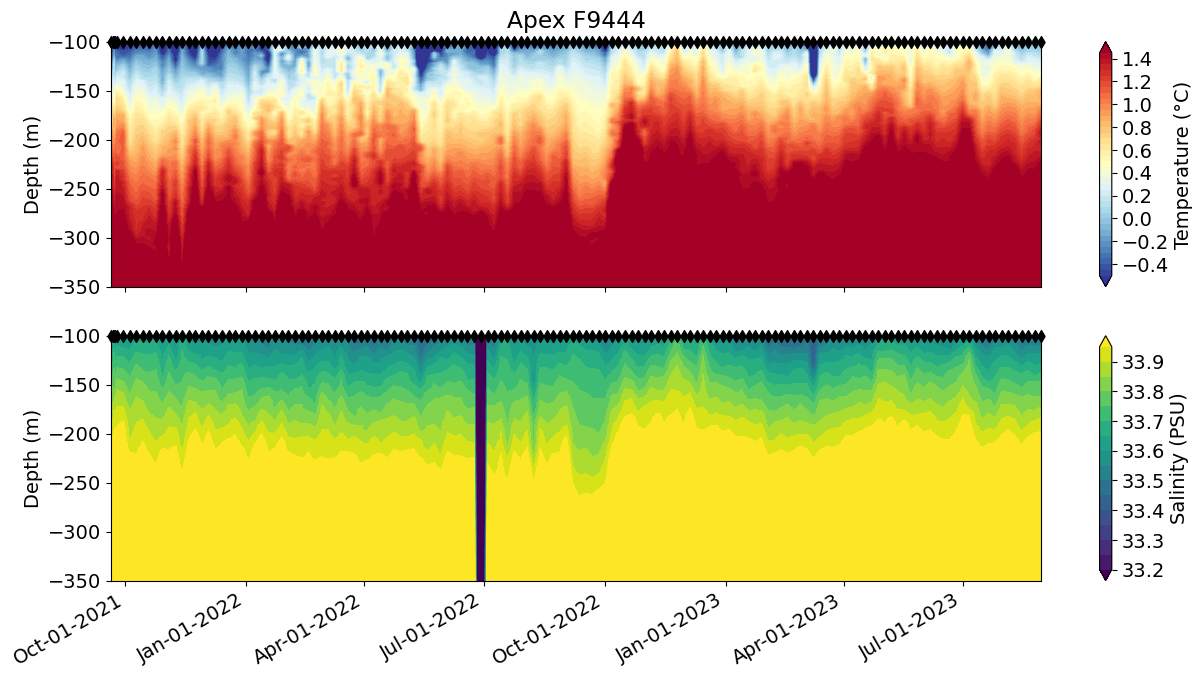

In [11]:
plot_float_data(float_num, float_model, ymin=-350, ymax=-100, temp_vmin=-0.5, temp_vmax=1.5, salt_vmin=33.2, salt_vmax=34, anomaly=False)

### APEX Float F9186 - *Upernavik Trough*

In [182]:
float_num   = 'F9186'
float_model = 'Apex'

In [109]:
# run function
F9186_data_ds = read_apex_float(float_num)

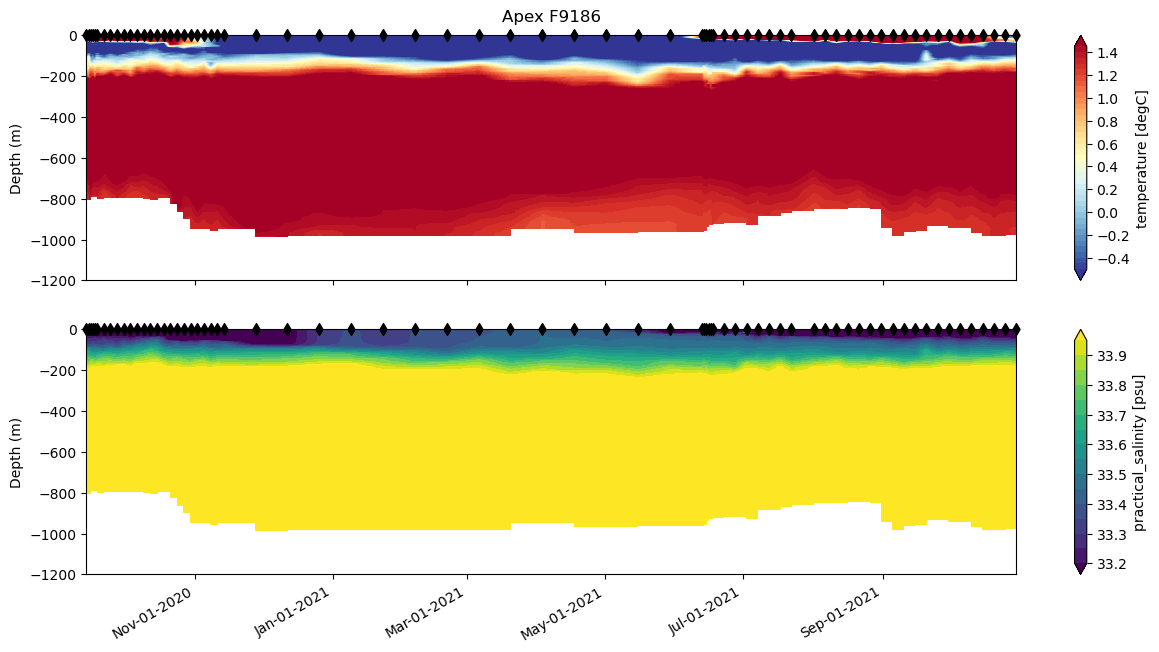

In [110]:
plot_float_data(float_num, float_model, ymin=-1200, ymax=0, temp_vmin=-0.5, temp_vmax=1.5, salt_vmin=33.2, salt_vmax=34)

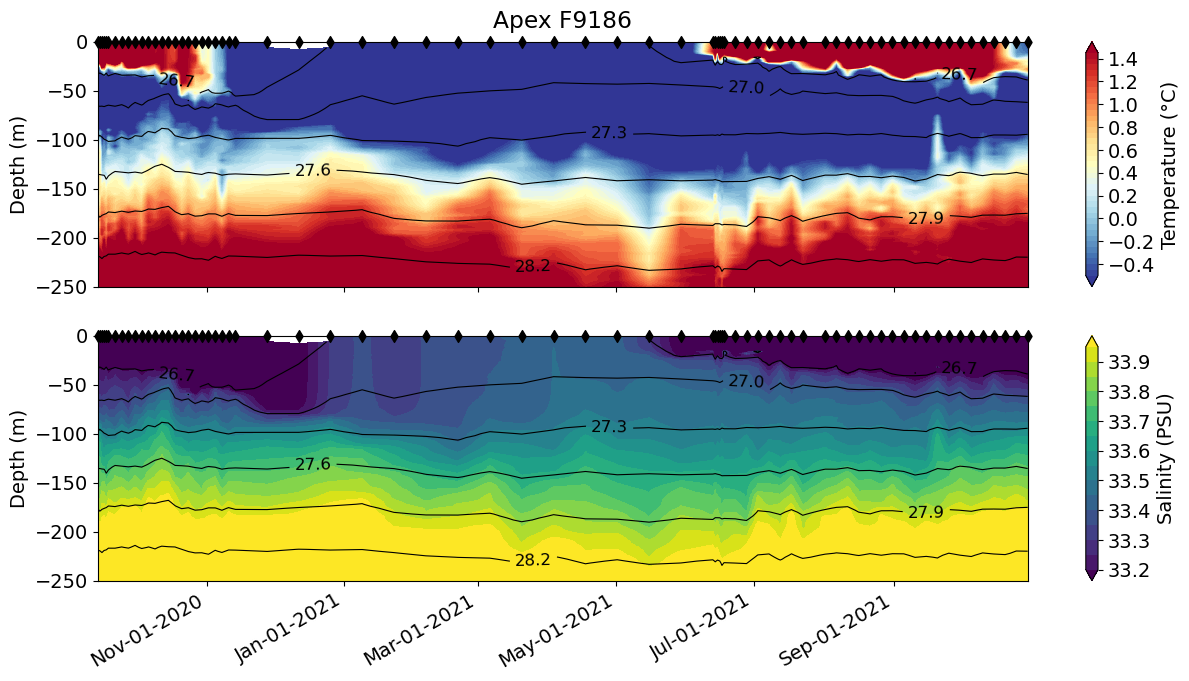

In [184]:
plot_float_data(float_num, float_model, ymin=-250, ymax=0, temp_vmin=-0.5, temp_vmax=1.5, salt_vmin=33.2, salt_vmax=34, anomaly=False)

### APEX Float F9443 - *Ummannaq Trough*

In [111]:
float_num   = 'F9443'
float_model = 'Apex'

In [112]:
# run function
F9443_data_ds = read_apex_float(float_num)

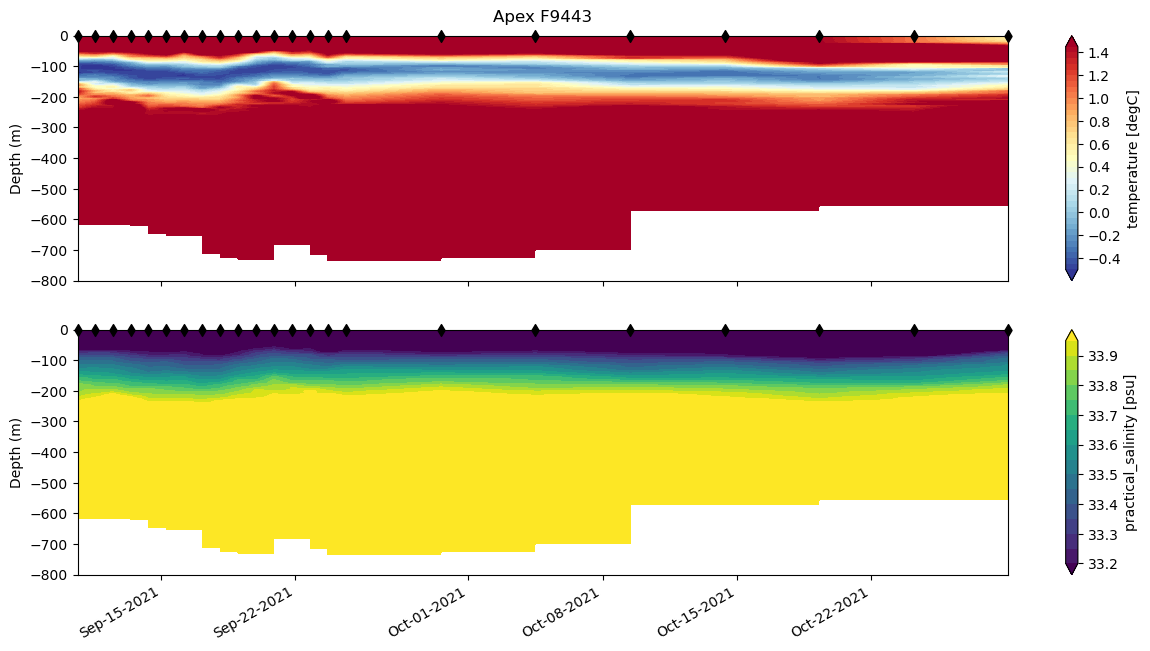

In [113]:
plot_float_data(float_num, float_model, ymin=-800, ymax=0, temp_vmin=-0.5, temp_vmax=1.5, salt_vmin=33.2, salt_vmax=34)

### APEX Float F9184 - *Disko Bay*

In [114]:
float_num   = 'F9184'
float_model = 'Apex'

In [115]:
# run function
F9184_data_ds = read_apex_float(float_num)

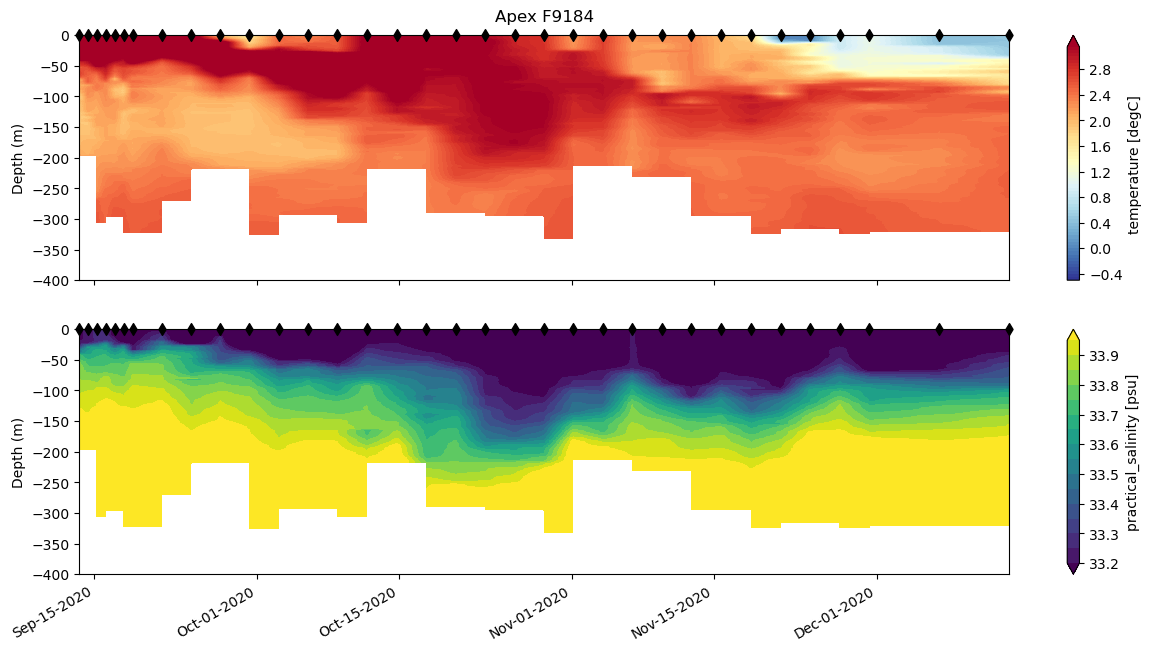

In [120]:
plot_float_data(float_num, float_model, ymin=-400, ymax=0, temp_vmin=-0.5, temp_vmax=3.2, salt_vmin=33.2, salt_vmax=34)

***

## Alamo Float data

*// Summary of floats:*

F9146

F9202

F9250

F9275

F9312

F9315

F9316


**Melville Bay** <br>
F9147 | 2017-10-18 to 2017-10-30 | *moved northward through trough* <br>

**Upernavik Trough**<br>

**Ummannaq Trough**<br>
F9147 | '2017-09-03 to 2018-01-16 |

**Disko Bay**<br>


In [4]:
def read_alamo_float(alamo_num):
    """
    Function that loops through all json files for a given float
    and extracts CTD profile data, saving it in raw and binned netCDF files.
    
    Returns dataset that contains all individual dives for the given float.
    """
    ## -------------------------------------------------------------------------------------
    ## Set directories for data files and where files will be saved: 
    parent_dir_alamo = '../../data/OMG_Float_data/OMG_Alamo_Float_Data/Alamo/'+alamo_num
    
    # Directory for ALAMO json files
    json_files_list = glob.glob(parent_dir_alamo+'/Processed/*.json')
    
    # NetCDF files for each dive (raw data from csv file)
    output_dir_dives_nc = Path(parent_dir_alamo+'/Dives_netcdf/')
    output_dir_dives_nc.mkdir(exist_ok = True, parents=True) # make directory if needed
    
    # Mean profiles averaged over depth bins (every 2 meters) for each dive
    output_dir_dives_binned_nc = Path(parent_dir_alamo+'/Dives_binned_netcdf/')
    output_dir_dives_binned_nc.mkdir(exist_ok = True, parents=True) # make directory if needed
    
    # Individual binned dives combined into one netCDF for each float
    output_dir_combined = Path(parent_dir_alamo+'/')
    
    ## -------------------------------------------------------------------------------------
    ## Loop through all data files (for each dive) and save individal and binned netCDF files
    
    for json_file in json_files_list:
        with open(json_file) as f:
            json_dict = json.load(f)
        
        # pull out metadata
        dive_dict = json_dict[0]['dives'][0]
        
        serial_num  = json_dict[0]['sn']
        float_model = json_dict[0]['model']
        dive_num    = dive_dict['dn']
        
        if dive_num > 0 and 'ascending' in dive_dict['science'].keys(): # Dive '0' is diagnostic
            # 'ascending' in dive_dict['science'].keys() ensures there is ascending CTD data (i.e., make sure it's a valid profile)
            gps_dive_start = [np.nan, np.nan]
            gps_dive_end   = [np.nan, np.nan]
            
            # pull out start_time and gps fixes -------------------------------------------------------------
            for dive_phase in dive_dict['status']['engineering']['other']:
                if dive_phase['kind'] =='Ascend':
                    start_time_dt = np.datetime64(dive_phase['fields'][0]['value'][:-1]) # take start time and remove 'Z' at end  
            
            # pull GPS fixes
            # there are times when the float cannot get a GPS fix (e.g., ice)
            if dive_dict['trajectory']['gps'] == []: # float was not able to get a fix before or after dive
                continue
            else:
                for gps in dive_dict['trajectory']['gps']:
                    if (gps['kind'] == 'DiveStart') and ([gps['lat'], gps['lon']] != [None,None]):
                        gps_dive_start = [gps['lat'], gps['lon']]
                        if gps_dive_start == [0,0]:
                            gps_dive_start = [np.nan, np.nan]
                    if (gps['kind'] == 'DiveEnd') and ([gps['lat'], gps['lon']] != [None,None]):
                        gps_dive_end   = [gps['lat'], gps['lon']]
                    else: continue
        
            print(gps_dive_end)
            
            # pull out data ---------------------------------------------------------------------------------
            # dive_dict['science']['units'] # units
            # dive_dict['status']['parameters'] # mission parameters (for acronym meaning look at txt file)
            data_dict = dive_dict['science']['ascending']['binned']
            
            # data_dict.keys() # list of variables measured by float: # dict_keys(['pressure', 'temperature', 'salinity'])
            pressure_array = np.array(data_dict['pressure'], dtype='float')
            temp_array     = np.array(data_dict['temperature'], dtype='float')
            salt_array     = np.array(data_dict['salinity'], dtype='float')
            
            # convert pressure to depth
            depth_array = gsw.z_from_p(pressure_array, lat=75.5)
            
            # make sure data arrays are same length as depth (pressure) arrays; if they do not, insert a np.nan
            # some floats were missing the last measurement at the surface (0 dBar) so there were length discrepencies
            if len(temp_array) != len(pressure_array):
                temp_array = np.append(temp_array, np.nan)
            if len(salt_array) != len(pressure_array):
                salt_array = np.append(salt_array, np.nan)
            
            # create Dataset for dive and save as netCDF
            dive_ds = xr.Dataset()
            dive_ds['pressure']           = xr.DataArray([pressure_array], dims=['dive','depth'], coords={'dive':[dive_num], 'depth':depth_array, 'date':('dive', [start_time_dt])})
            dive_ds['pressure'].attrs     = {'standard_name':'pressure', 'units': 'dBar'}
            dive_ds['temperature']        = xr.DataArray([temp_array], dims=['dive','depth'], coords={'dive':[dive_num], 'depth':depth_array, 'date':('dive', [start_time_dt])})
            dive_ds['temperature'].attrs  = {'standard_name':'temperature', 'units': 'degC', 'comments':'In-situ temperature (ITS-90)'}
            dive_ds['salinity']           = xr.DataArray([salt_array], dims=['dive','depth'], coords={'dive':[dive_num], 'depth':depth_array, 'date':('dive', [start_time_dt])})
            dive_ds['salinity'].attrs     = {'standard_name':'practical_salinity', 'units': 'psu'}
            
            # add lat/lon nondimensional coordinates and
            # Take the DiveEnd GPS coordinates because this fix is the closest estimate for where the float was during the CTD profile (during ascent)
            # If those aren't available, then take the DiveStart gps fix
            # gps fixes will be flagged in 'gps_flag' coordinate when DiveStart was used or when none were available
            if (np.nan in gps_dive_end) or (0 in gps_dive_end):
                dive_ds = dive_ds.assign_coords({'lat':('dive', [gps_dive_start[0]])})
                dive_ds = dive_ds.assign_coords({'lon':('dive', [gps_dive_start[1]])})
                # add '1' for 'gps_flag' (= invalid gps fix)
                dive_ds = dive_ds.assign_coords({'gps_flag':('dive', [1])})
            else:
                dive_ds = dive_ds.assign_coords({'lat':('dive', [gps_dive_end[0]])})
                dive_ds = dive_ds.assign_coords({'lon':('dive', [gps_dive_end[1]])})
                # add '0' for 'gps_flag' (= valid gps fix)
                dive_ds = dive_ds.assign_coords({'gps_flag':('dive', [0])})

            # add metadata
            dive_ds['dive'].attrs     = {'comments':'Dive number'}
            dive_ds['depth'].attrs    = {'units': 'meters','comments':'Depth in meters calculated from pressure'}
            dive_ds['date'].attrs     = {'comments':'Indicates ascent start time when profile begins'}
            dive_ds['lat'].attrs      = {'units': 'degrees','comments':'Latitude of profile'}
            dive_ds['lon'].attrs      = {'units': 'degrees','comments':'Longitude of profile'}
            dive_ds['gps_flag'].attrs = {'comments':'Flag indicating valid (0) or invalid (1) GPS fix. Invalid GPS fixes arise when the float could not obtain a fix when it surfaced after CTD profiling during the ascent mission. If available, a GPS fix from the beginning of the dive was provided as the closest approximation.'}
            
            # save netcdf to disk      
            filename_tmp = json_file.split('\\')[1][:40] + '.nc'                                         
            dive_ds.to_netcdf(output_dir_dives_nc / filename_tmp)
            dive_ds.close()
            
            # create binned datasets:
            # # first, fill any gaps (nans) in CTD profiles
            # dive_ds_fill = dive_ds.interpolate_na(dim='depth')
            
            # now bin and average data every 2 meters and save new netcdf
            bins = np.arange(-1202,2,2) # create predetermined bins from 0 to 1200 meters
            binned_ds = dive_ds.groupby_bins('depth',bins,labels=bins[1:]).mean(skipna=True) # group and average data across each bin
            # binned_ds.coords['depth_bins'] = xr.DataArray(bins[1:], dims=['depth_bins']) # reassign coordinate values to be bins
            
            # copy over variable attributes from original dataset to binned dataset
            binned_ds.pressure.attrs     = dive_ds.pressure.attrs
            binned_ds.temperature.attrs  = dive_ds.temperature.attrs
            binned_ds.salinity.attrs     = dive_ds.salinity.attrs
            
            filename_binned = json_file.split('\\')[1][:40] + '_binned.nc'
            binned_ds.to_netcdf(output_dir_dives_binned_nc / filename_binned)
            binned_ds.close()
            
    # Load all netCDF DataArrays and create combined Dataset for float
    files = list(output_dir_dives_binned_nc.glob('*nc'))

    all_dives_float_ds = xr.open_mfdataset(files,combine='nested', \
                                           concat_dim='dive', parallel=True,\
                                           data_vars='all', coords='all')
    
    # add metadata
    all_dives_float_ds.attrs['Float_type'] = float_model
    all_dives_float_ds.attrs['Float_number'] = serial_num
    all_dives_float_ds.depth_bins.attrs = {'units': 'meters','comments':'Binned depths used for mean profiles'}
    
    # save new, combined dataset
    filename_combined = 'ALAMO_' + alamo_num + '_profiles_binned.nc'
    # create encoding using function defined above
    new_encoding = create_encoding(all_dives_float_ds)
    all_dives_float_ds.to_netcdf(output_dir_combined / filename_combined, encoding=new_encoding)
    all_dives_float_ds.close()
    
    return all_dives_float_ds

### ALAMO Float F9147 - *Melville Bay*

In [89]:
float_num = 'F9147'
float_model = 'Alamo'

In [ ]:
F9147_data_ds = read_alamo_float(float_num)

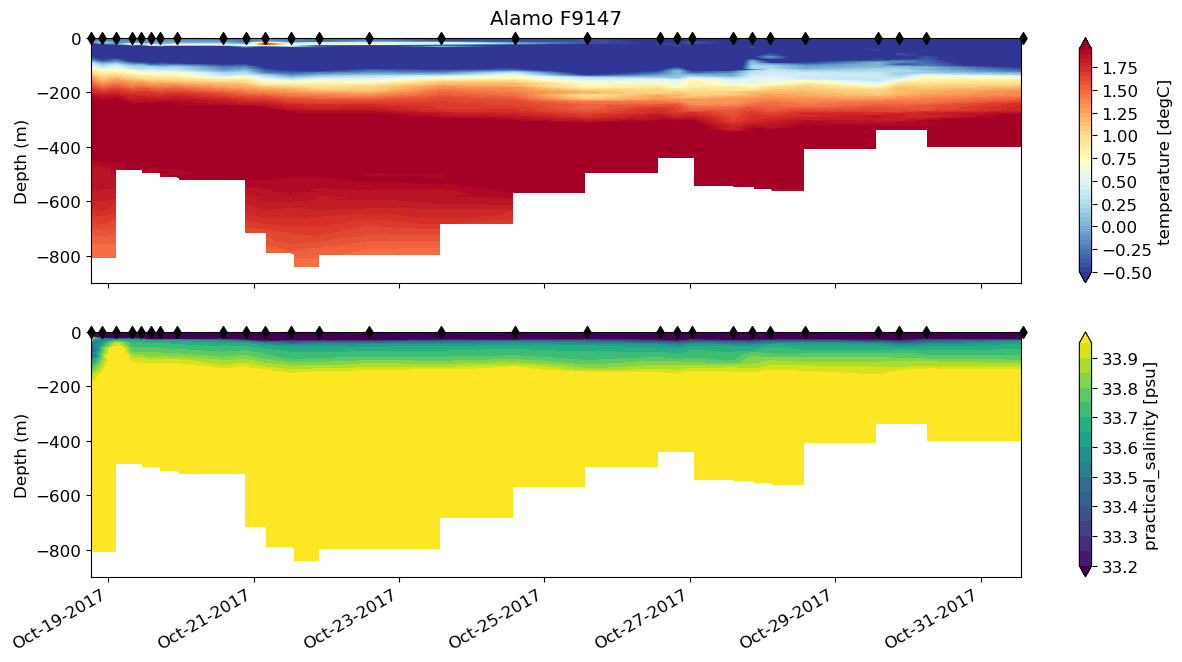

In [75]:
plot_float_data(float_num, float_model, ymin=-900, ymax=0, temp_vmin=-0.5, temp_vmax=2, salt_vmin=33.2, salt_vmax=34)

### ALAMO Float F9146 - *Upernavik Trough*

In [86]:
float_num = 'F9146'
float_model = 'Alamo'

In [87]:
F9146_data_ds = read_alamo_float(float_num)

[73.0721591, -56.1727831]
[73.0724889, -56.1717985]
[73.0720751, -56.1758199]
[73.0742892, -56.2185842]
[73.0753951, -56.2212008]
[nan, nan]
[73.108379, -56.2397063]
[73.1150437, -56.2478819]
[73.1155033, -56.250907]
[73.1161934, -56.2537182]
[73.1170971, -56.2537592]
[73.3480613, -56.8187473]


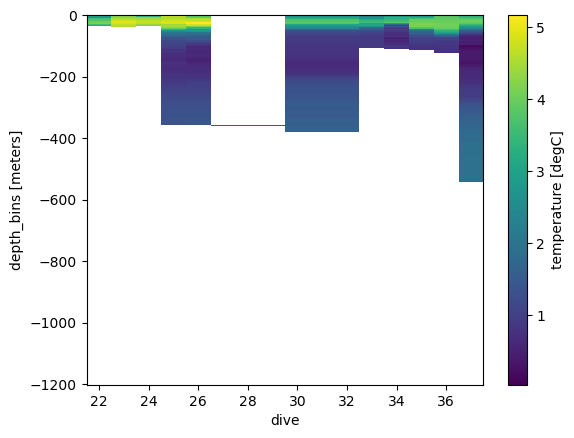

In [98]:
F9146_data_ds.temperature.plot()

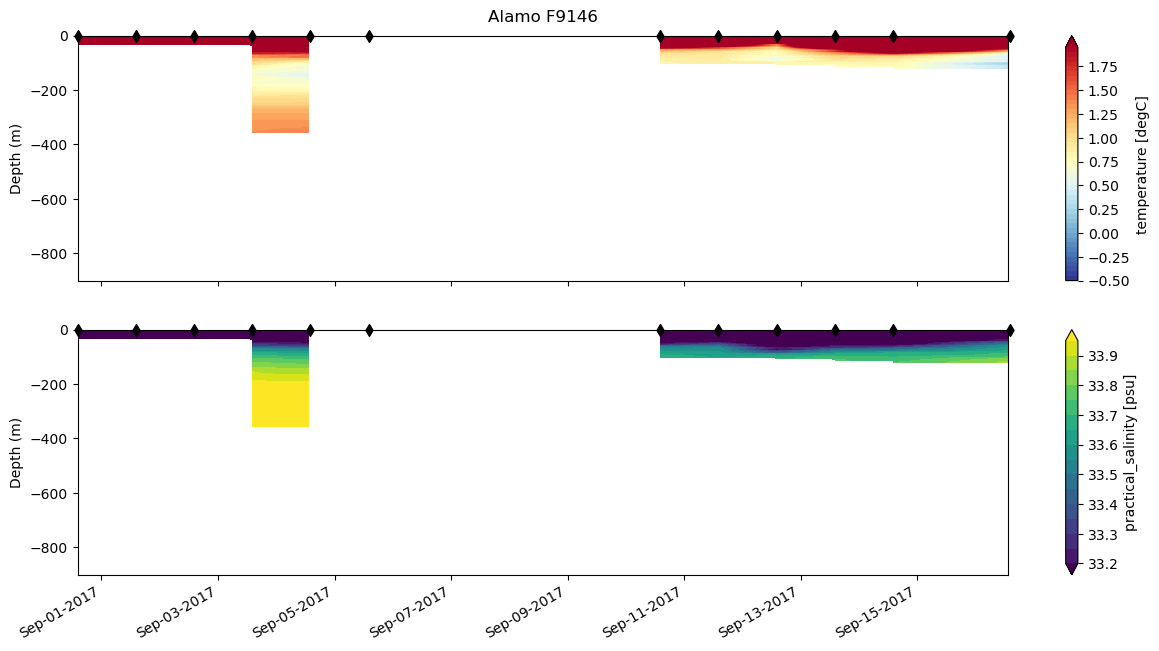

In [97]:
plot_float_data(float_num, float_model, ymin=-900, ymax=0, temp_vmin=-0.5, temp_vmax=2, salt_vmin=33.2, salt_vmax=34)

### ALAMO Float F9202 - *Upernavik Trough and Baffin Bay*

In [32]:
float_num = 'F9202'
float_model = 'Alamo'

In [33]:
F9202_data_ds = read_alamo_float(float_num)

[73.3597788, -58.1600147]
[73.3772892, -58.4735968]
[73.3701593, -58.5121273]
[73.360192, -58.5468401]
[73.3484567, -58.5725254]
[73.3387185, -58.5848583]
[73.3317853, -58.5878881]
[73.3268505, -58.5875818]
[73.3223873, -58.5917093]
[73.3174756, -58.6008156]
[73.3108388, -58.6156072]
[73.3028626, -58.6360086]
[73.2944692, -58.6550517]
[73.286936, -58.6725289]
[73.2807311, -58.6839009]
[73.277379, -58.6944857]
[73.277008, -58.7094441]
[73.2779379, -58.73545]
[73.279513, -58.7747973]
[73.2813289, -58.8188502]
[73.2836512, -58.8610839]
[73.2844404, -58.9066576]
[73.2850974, -58.961971]
[73.2765844, -58.9981405]
[73.2423133, -59.1377893]
[73.2163368, -59.2263978]
[73.186819, -59.3320156]
[73.1837492, -59.4015223]
[73.164081, -59.4435308]
[73.155667, -59.4762082]
[73.1304395, -59.5211469]
[73.1237091, -59.5551417]
[73.1057376, -59.6075772]
[73.0889146, -59.6458086]
[73.0718536, -59.7195693]
[73.0616267, -59.7830544]
[73.0509645, -59.8266979]
[73.0188994, -59.9204018]
[73.0050408, -59.980890

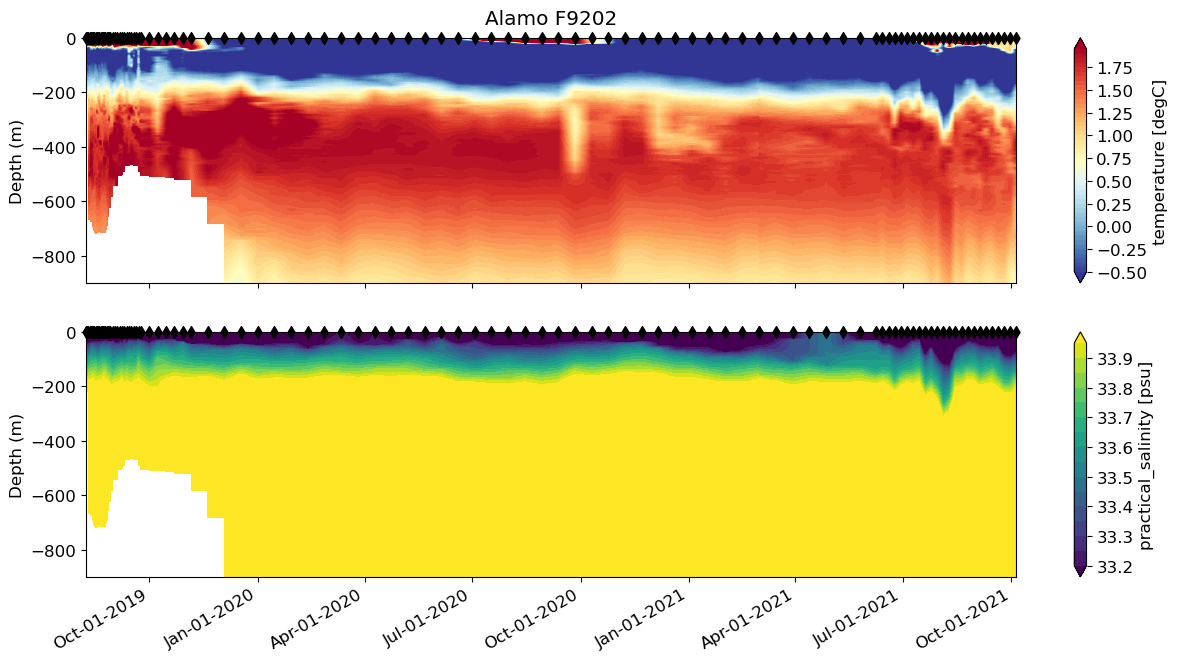

In [34]:
plot_float_data(float_num, float_model, ymin=-900, ymax=0, temp_vmin=-0.5, temp_vmax=2, salt_vmin=33.2, salt_vmax=34)

***

### ALAMO Float F9145 - *Ummannaq Trough*

In [82]:
float_num = 'F9145'
float_model = 'Alamo'

In [83]:
F9145_data_ds = read_alamo_float(float_num)

[70.9038194, -55.3500846]
[nan, nan]
[71.0950877, -55.1340789]
[71.1050329, -55.1164418]
[nan, nan]
[71.1571275, -55.0566722]
[71.1677978, -55.0213004]
[71.1749535, -54.9700897]
[71.318822, -54.2571271]
[71.2879305, -54.1807191]
[71.2894418, -54.1833882]
[71.2904312, -54.1802733]
[71.2920447, -54.1814283]
[71.3113746, -54.2226808]
[71.3204963, -54.342778]
[71.3027841, -54.3883101]
[71.281904, -54.4791272]
[71.2425629, -54.4822734]
[71.2161682, -54.5024096]
[71.1679669, -54.5563828]
[71.1529065, -54.57903]
[71.1198308, -54.5718926]
[nan, nan]
[nan, nan]
[71.03508, -54.8713844]
[71.020434, -54.9412252]
[71.0022624, -54.8702869]
[70.9737777, -54.9450855]
[70.9720169, -55.0556209]
[70.9670164, -55.0972678]
[70.9482876, -54.9910485]
[70.9722059, -54.6526591]
[70.9951057, -54.6120344]
[nan, nan]
[71.0341368, -54.5105151]
[70.9233097, -54.4935001]
[70.9452293, -54.5881627]
[nan, nan]
[70.9039214, -54.6476217]
[70.9547973, -54.7860279]
[70.9930747, -54.6140286]
[70.9793253, -54.8153393]
[71.01

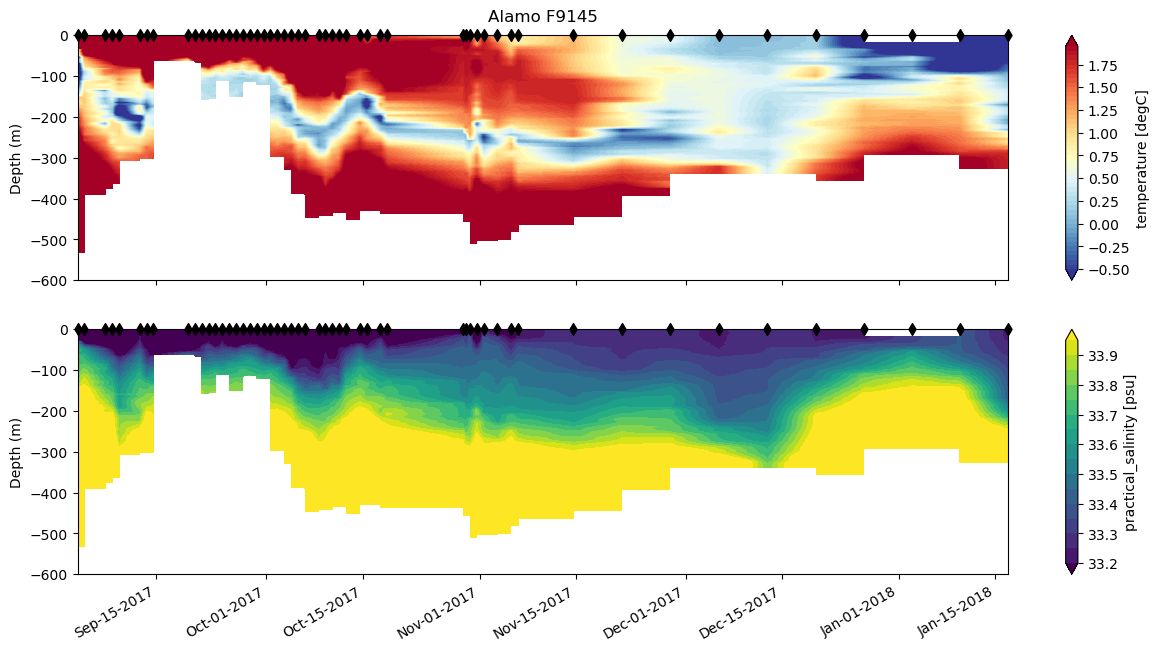

In [84]:
plot_float_data(float_num, float_model, ymin=-600, ymax=0, temp_vmin=-0.5, temp_vmax=2, salt_vmin=33.2, salt_vmax=34)

### ALAMO Float F9316 - *Ummannaq Trough*

In [25]:
float_num = 'F9316'
float_model = 'Alamo'

In [26]:
F9316_data_ds = read_alamo_float(float_num)

[0.0, 0.0]
[0.0, 0.0]
[70.8343527, -53.3440814]
[70.8323806, -53.3332499]
[70.822936, -53.3499412]
[70.8169679, -53.3246298]
[70.816533, -53.3237331]
[70.8132084, -53.3008849]
[70.8126188, -53.2883741]
[70.8122112, -53.2875015]
[70.8115771, -53.2762482]
[70.8058135, -53.2939178]
[70.8045608, -53.2785654]
[70.8029968, -53.2715436]
[70.8001722, -53.2754837]
[70.7972501, -53.3018027]
[70.7952881, -53.3334882]
[70.7933333, -53.352925]
[70.7887545, -53.3721384]
[70.7918268, -53.3949379]
[70.7897985, -53.4306569]
[70.7922246, -53.4508319]
[70.7971306, -53.4722647]
[70.7996945, -53.4859168]
[70.7959679, -53.469096]
[70.7886587, -53.4257203]
[70.7862589, -53.4244176]


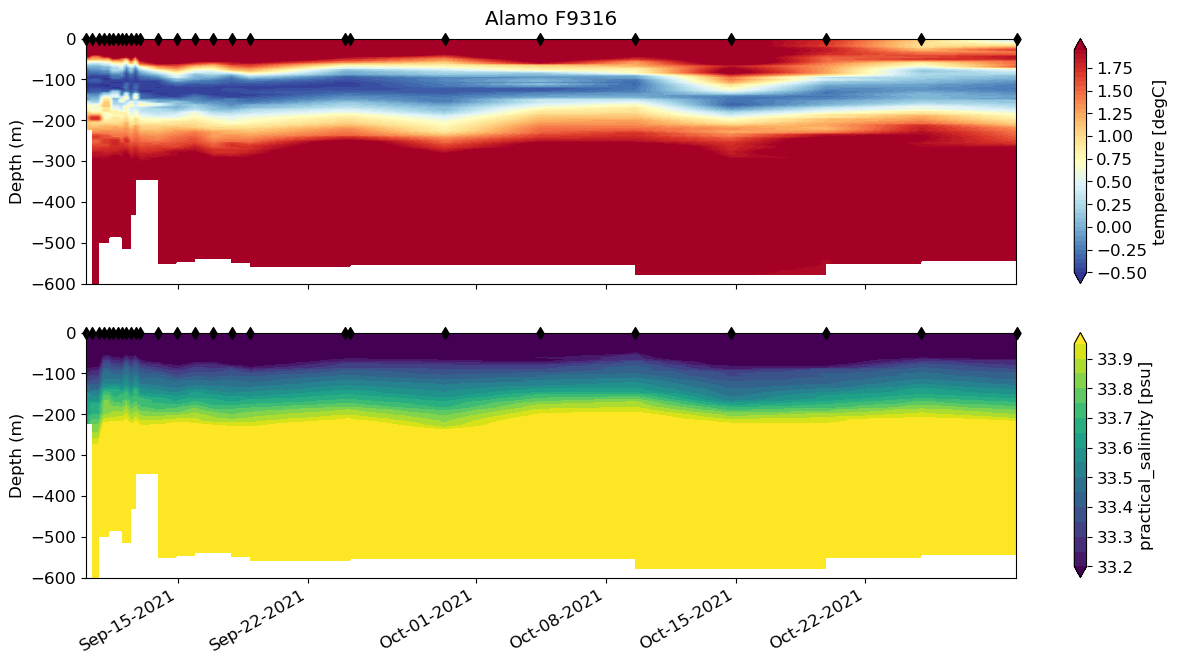

In [27]:
plot_float_data(float_num, float_model, ymin=-600, ymax=0, temp_vmin=-0.5, temp_vmax=2, salt_vmin=33.2, salt_vmax=34)

### ALAMO Float F9250 - *Disko Bay*

In [39]:
float_num = 'F9250'
float_model = 'Alamo'

In [40]:
F9250_data_ds = read_alamo_float(float_num)

[69.0639625, -51.7082966]
[0.0, 0.0]
[69.0487731, -51.7572453]
[69.0461087, -51.7688878]
[0.0, 0.0]
[0.0, 0.0]
[0.0, 0.0]
[69.0388305, -51.8475005]
[69.0394825, -51.8620446]
[0.0, 0.0]
[69.0398999, -51.8948236]
[69.0395211, -51.8998249]
[69.0387361, -51.9096176]
[69.0382753, -51.9116542]
[69.0380455, -51.9210261]
[69.0394275, -51.9316842]
[69.0410894, -51.9420286]
[69.0431877, -51.9458348]
[69.0447917, -51.9459649]
[69.0460312, -51.9460206]
[69.0462803, -51.9494474]
[69.046524, -51.9575268]
[69.047149, -51.9638311]
[69.0477663, -51.963856]
[69.0481337, -51.9670799]
[69.0496028, -51.9814288]
[69.050384, -51.9789275]
[69.0495181, -51.9756199]
[69.0459446, -51.9862706]
[69.045889, -51.9893134]
[69.0466481, -51.9820487]
[69.0462344, -51.9959682]
[69.0474429, -51.9997573]
[69.0471545, -51.994513]
[69.046156, -51.9920468]
[69.0464014, -51.9903584]
[69.04591, -51.9848156]
[69.048156, -51.9838267]
[69.0506571, -51.979862]
[69.0517091, -51.9760342]
[69.0514693, -51.9760421]
[69.05676, -51.96439

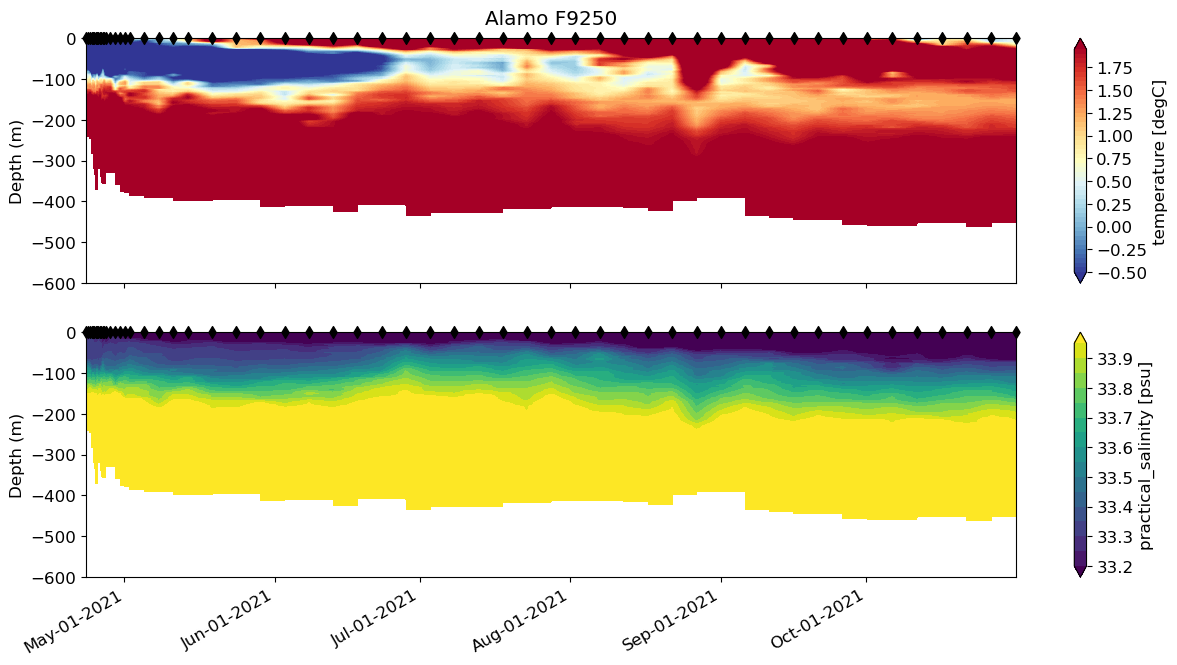

In [41]:
plot_float_data(float_num, float_model, ymin=-600, ymax=0, temp_vmin=-0.5, temp_vmax=2, salt_vmin=33.2, salt_vmax=34)

### ALAMO Float F9312 - *Cape Farewell*

In [58]:
float_num = 'F9312'
float_model = 'Alamo'

In [6]:
F9312_data_ds = read_alamo_float(float_num)

[0.0, 0.0]
[0.0, 0.0]
[0.0, 0.0]
[0.0, 0.0]
[0.0, 0.0]
[0.0, 0.0]
[0.0, 0.0]
[0.0, 0.0]
[0.0, 0.0]
[0.0, 0.0]
[0.0, 0.0]
[0.0, 0.0]
[0.0, 0.0]
[0.0, 0.0]
[0.0, 0.0]
[0.0, 0.0]
[0.0, 0.0]
[0.0, 0.0]
[0.0, 0.0]
[0.0, 0.0]
[0.0, 0.0]
[0.0, 0.0]
[0.0, 0.0]
[0.0, 0.0]
[0.0, 0.0]
[0.0, 0.0]
[0.0, 0.0]
[0.0, 0.0]
[0.0, 0.0]
[0.0, 0.0]
[0.0, 0.0]
[0.0, 0.0]
[0.0, 0.0]
[0.0, 0.0]
[0.0, 0.0]
[0.0, 0.0]
[0.0, 0.0]
[0.0, 0.0]
[0.0, 0.0]
[0.0, 0.0]
[0.0, 0.0]
[0.0, 0.0]
[0.0, 0.0]
[0.0, 0.0]
[0.0, 0.0]
[0.0, 0.0]
[0.0, 0.0]
[0.0, 0.0]
[0.0, 0.0]
[0.0, 0.0]
[0.0, 0.0]
[0.0, 0.0]
[0.0, 0.0]
[0.0, 0.0]
[0.0, 0.0]
[0.0, 0.0]
[0.0, 0.0]
[0.0, 0.0]
[0.0, 0.0]
[0.0, 0.0]
[0.0, 0.0]
[0.0, 0.0]
[0.0, 0.0]
[0.0, 0.0]
[60.2452507, -42.211913]
[60.1995682, -42.1587238]
[60.1336226, -42.186342]
[60.1051227, -42.2651379]
[60.1323364, -42.3704931]
[60.1369905, -42.5006274]
[60.1426226, -42.568775]
[60.121068, -42.5915667]
[60.1051387, -42.590455]
[60.084175, -42.5895828]
[60.0736226, -42.5880778]
[60.0645601, -42

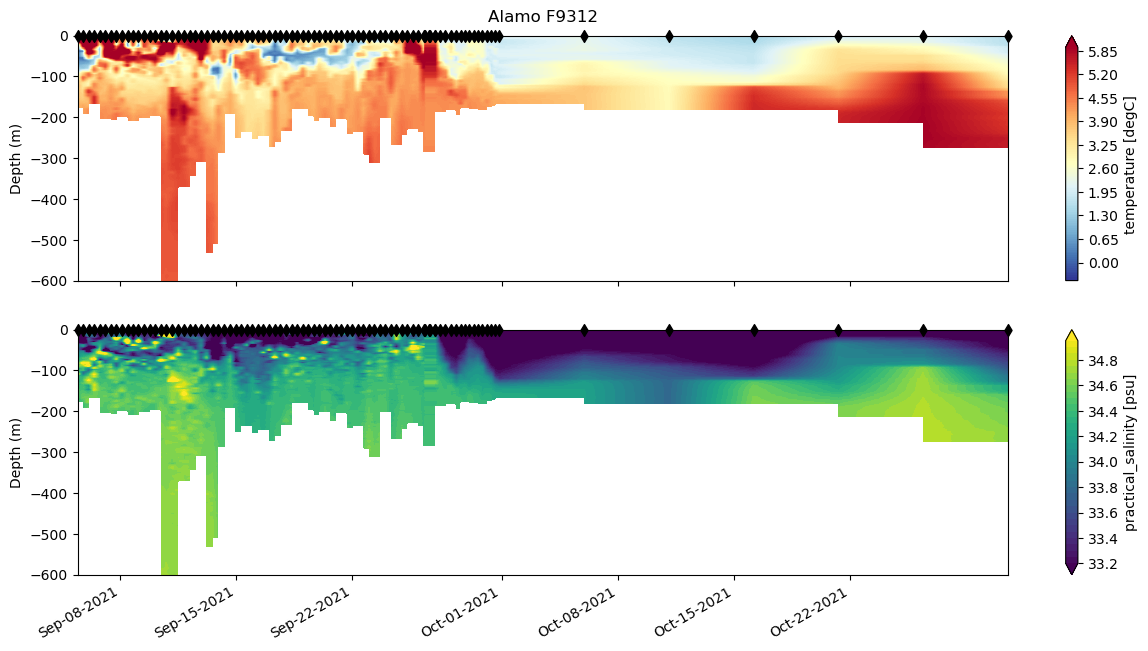

In [59]:
plot_float_data(float_num, float_model, ymin=-600, ymax=0, temp_vmin=-0.5, temp_vmax=6, salt_vmin=33.2, salt_vmax=35)

### ALAMO Float F9275 - *SE Greenland*

In [60]:
float_num = 'F9275'
float_model = 'Alamo'

In [43]:
F9275_data_ds = read_alamo_float(float_num)

[65.5531394, -37.3539052]
[65.5517037, -37.3668366]
[65.5583037, -37.3610635]
[65.5547418, -37.3665531]
[65.5590165, -37.3528181]
[65.5553418, -37.3457157]
[65.5498468, -37.3421652]
[65.5385248, -37.3337839]
[65.5274913, -37.3313725]
[65.5253854, -37.335133]
[65.5252187, -37.3466152]
[65.5233964, -37.3383172]
[65.4947761, -37.386528]
[65.5079903, -37.439259]
[65.5082731, -37.4686691]
[65.5140821, -37.4832702]
[65.514824, -37.5029057]
[65.4976878, -37.633805]
[65.4870525, -37.747418]
[65.4887084, -37.8343252]
[65.5022657, -37.88486]
[65.5187822, -37.9390431]
[65.5247208, -38.0083372]
[65.5241088, -38.0585684]
[65.5246737, -38.1029983]
[65.5296306, -38.1328849]
[65.5288227, -38.1874429]
[65.5060776, -38.2440121]


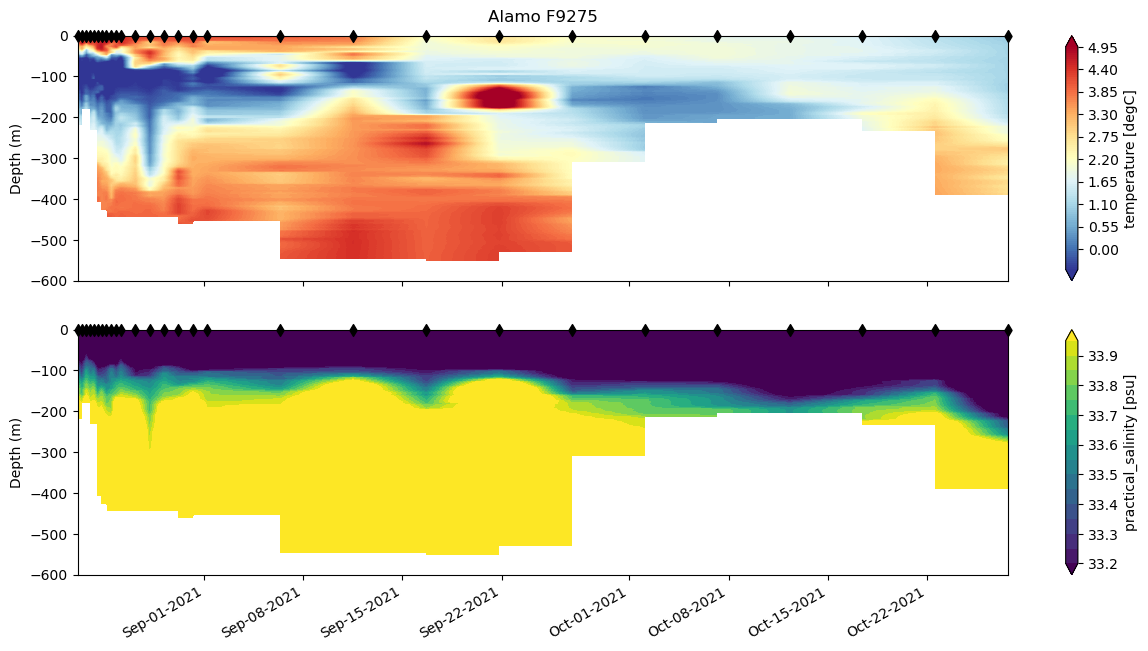

In [61]:
plot_float_data(float_num, float_model, ymin=-600, ymax=0, temp_vmin=-0.5, temp_vmax=5, salt_vmin=33.2, salt_vmax=34)

### ALAMO Float F9315 - *NE Greenland*

In [63]:
float_num = 'F9315'
float_model = 'Alamo'

In [15]:
F9315_data_ds = read_alamo_float(float_num)

[0.0, 0.0]
[0.0, 0.0]
[0.0, 0.0]
[78.2579685, -16.7035097]
[78.241157, -16.6682414]
[78.2246449, -16.6614934]
[0.0, 0.0]
[0.0, 0.0]
[0.0, 0.0]
[0.0, 0.0]
[78.1402037, -16.5441613]
[0.0, 0.0]
[78.0974448, -16.3935504]
[77.9952529, -15.9284159]
[77.9849503, -15.8942525]
[0.0, 0.0]
[0.0, 0.0]
[77.9029698, -14.9715741]
[0.0, 0.0]
[77.8391673, -15.1170392]
[77.8495801, -15.1593083]


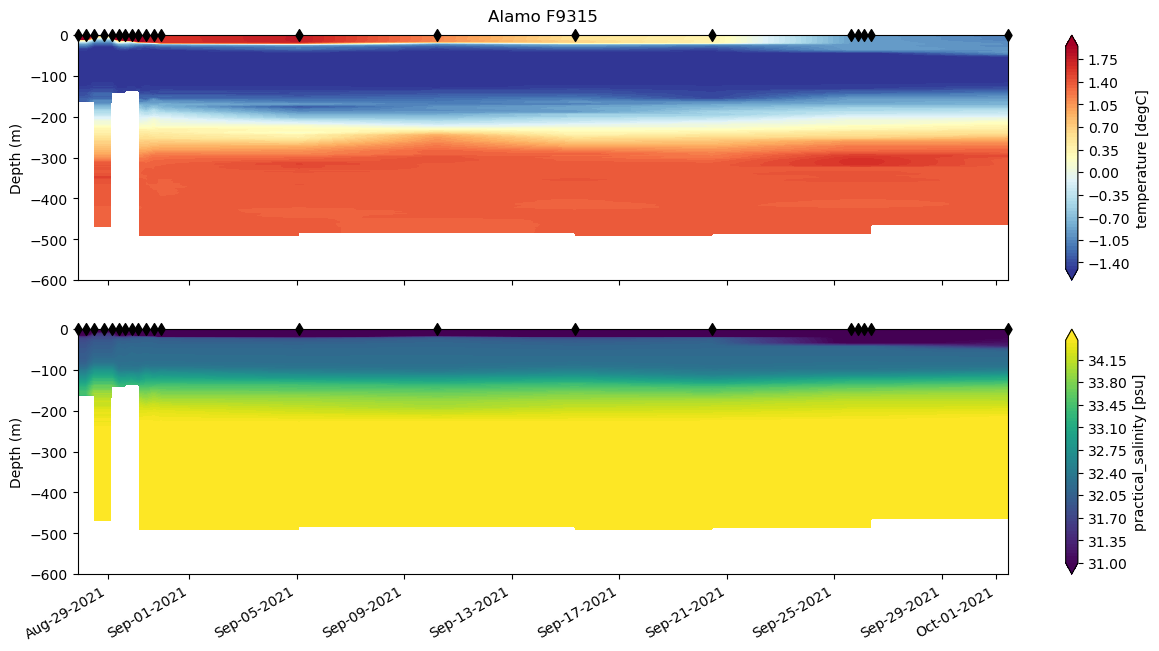

In [76]:
plot_float_data(float_num, float_model, ymin=-600, ymax=0, temp_vmin=-1.5, temp_vmax=2, salt_vmin=31, salt_vmax=34.5)

## Plot map of dive locations for all floats in Baffin Bay

In [69]:
from matplotlib import cm
import matplotlib as mpl
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cmocean
from matplotlib.colors import ListedColormap

Load bathymetry

In [70]:
bathy_geb = xr.open_dataset('../../data/bathymetry/GEBCO/gebco_2021_n90.0_s30.0_w-120.0_e30.0.nc')

In [71]:
bathy_select = bathy_geb.elevation.isel(lat=slice(0,None,5), lon=slice(0,None,5)).sel(lat=slice(50,90), lon=slice(-90,15))

Load APEX and ALAMO GPS coordinates

In [72]:
# APEX
apex_dir = Path('../../data/OMG_Float_data/OMG_APEX_Float_Data/APEX')

# interpolate and plot
F9185_data_ds = xr.open_dataset(apex_dir / 'F9185/APEX_F9185_profiles_binned.nc')
F9444_data_ds = xr.open_dataset(apex_dir / 'F9444/APEX_F9444_profiles_binned.nc')
F9186_data_ds = xr.open_dataset(apex_dir / 'F9186/APEX_F9186_profiles_binned.nc')
F9443_data_ds = xr.open_dataset(apex_dir / 'F9443/APEX_F9443_profiles_binned.nc')
F9184_data_ds = xr.open_dataset(apex_dir / 'F9184/APEX_F9184_profiles_binned.nc')

In [4]:
# ALAMO
alamo_dir = Path('../../../data/OMG_Float_data/OMG_ALAMO_Float_Data/ALAMO')

# interpolate and plot
F9145_data_ds = xr.open_dataset(alamo_dir / 'F9145/ALAMO_F9145_profiles_binned.nc')
F9146_data_ds = xr.open_dataset(alamo_dir / 'F9146/ALAMO_F9146_profiles_binned.nc')
F9147_data_ds = xr.open_dataset(alamo_dir / 'F9147/ALAMO_F9147_profiles_binned.nc')
F9202_data_ds = xr.open_dataset(alamo_dir / 'F9202/ALAMO_F9202_profiles_binned.nc')
F9250_data_ds = xr.open_dataset(alamo_dir / 'F9250/ALAMO_F9250_profiles_binned.nc')
F9275_data_ds = xr.open_dataset(alamo_dir / 'F9275/ALAMO_F9275_profiles_binned.nc')
F9312_data_ds = xr.open_dataset(alamo_dir / 'F9312/ALAMO_F9312_profiles_binned.nc')
F9315_data_ds = xr.open_dataset(alamo_dir / 'F9315/ALAMO_F9315_profiles_binned.nc')
F9316_data_ds = xr.open_dataset(alamo_dir / 'F9316/ALAMO_F9316_profiles_binned.nc')

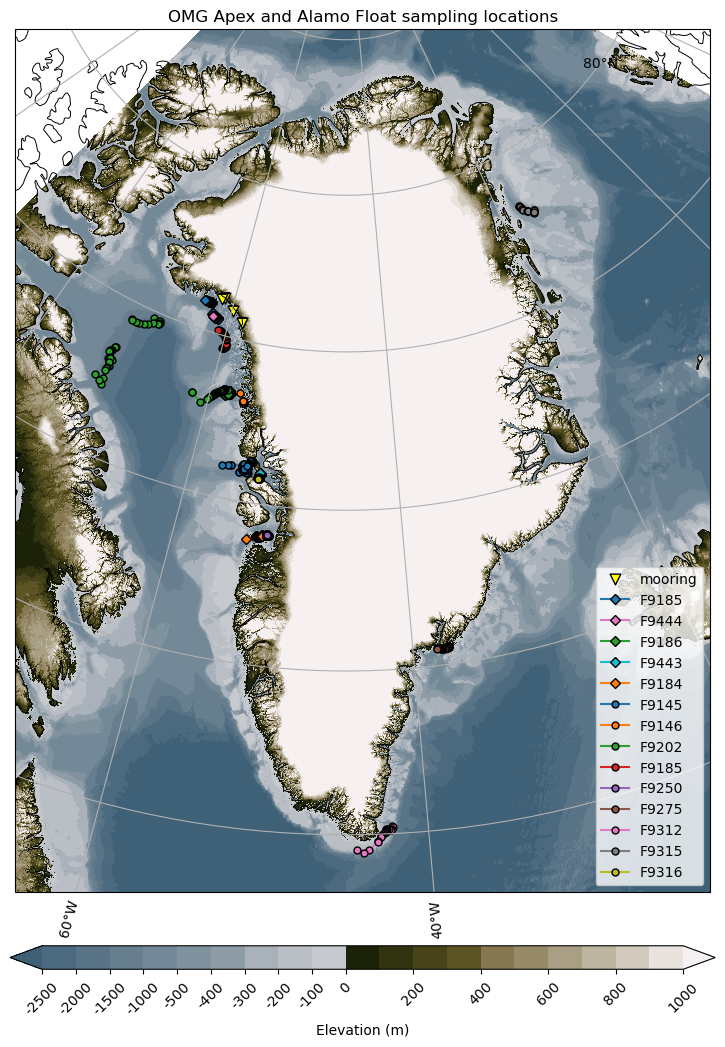

In [44]:
plt.figure(figsize=(13,14))
plt.rcParams['font.size'] = '10'

ax = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude = -45))
# ax.set_extent([-66.5, -49, 68, 77], ccrs.PlateCarree())
ax.set_extent([-64, -24, 58, 85], ccrs.PlateCarree())

# define top and bottom colormaps 
top        = cm.get_cmap(cmocean.cm.diff, 11)
bottom     = cm.get_cmap(cmocean.cm.diff_r, 12)
newcolors  = np.vstack((top(np.linspace(0.15, 0.4, 11)),
                       bottom(np.linspace(0, 0.5, 12)))) # create a new colormaps
ocean_land = ListedColormap(newcolors, name='ocean_land')
bounds     = [-2500,-2000,-1500,-1000,-500,-400,-300,-200,-100,0,100,200,300,400,500,600,700,800,900,1000]
ticks      = [-2500,-2000,-1500,-1000,-500,-400,-300,-200,-100,0,200,400,600,800,1000]

pc   = bathy_select.plot.pcolormesh('lon','lat',ax=ax,transform=ccrs.PlateCarree(),shading='auto',rasterized=True,cmap=ocean_land,levels=bounds,add_colorbar=False)
cbar = plt.colorbar(pc, label='Elevation (m)',ticks=ticks,boundaries=bounds,orientation='horizontal',shrink=0.7,spacing='uniform',pad=0.05,aspect=30)
cbar.ax.set_xticklabels(ticks,rotation=45)

ax.coastlines(linewidths=0.7)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl.top_labels = False
gl.left_labels = True
gl.right_labels = True

# add markers for mooring loccations
ax.scatter(-58.410533, 75.5413, s=60, c='yellow',edgecolor='black',marker="v",transform=ccrs.PlateCarree(), label='mooring')
ax.scatter(-59.8429, 75.843683, s=60, c='yellow',edgecolor='black',marker="v",transform=ccrs.PlateCarree()) 
ax.scatter(-61.279117, 76.160533, s=60, c='yellow',edgecolor='black',marker="v",transform=ccrs.PlateCarree())
ax.scatter(-61.726983, 76.103817, s=60, c='yellow',edgecolor='black',marker="v",transform=ccrs.PlateCarree()) 

# add apex float coordinates
ax.plot(F9185_data_ds.lon,F9185_data_ds.lat,'-D', color='tab:blue', markersize=5, markeredgecolor='k', transform=ccrs.PlateCarree(), label="F9185")
ax.plot(F9444_data_ds.lon,F9444_data_ds.lat,'-D', color='tab:pink', markersize=5, markeredgecolor='k', transform=ccrs.PlateCarree(), label="F9444")
ax.plot(F9186_data_ds.lon,F9186_data_ds.lat,'-D', color='tab:green', markersize=5, markeredgecolor='k', transform=ccrs.PlateCarree(), label="F9186")
ax.plot(F9443_data_ds.lon,F9443_data_ds.lat,'-D', color='tab:cyan', markersize=5, markeredgecolor='k', transform=ccrs.PlateCarree(), label="F9443")
ax.plot(F9184_data_ds.lon,F9184_data_ds.lat,'-D', color='tab:orange', markersize=5, markeredgecolor='k', transform=ccrs.PlateCarree(), label="F9184")

# add alamo float coordinates
ax.plot(F9145_data_ds.lon,F9145_data_ds.lat,'-o', markersize=5, markeredgecolor='k', transform=ccrs.PlateCarree(), label="F9145")
ax.plot(F9146_data_ds.lon,F9146_data_ds.lat,'-o', markersize=5, markeredgecolor='k', transform=ccrs.PlateCarree(), label="F9146")
ax.plot(F9202_data_ds.lon,F9202_data_ds.lat,'-o', markersize=5, markeredgecolor='k', transform=ccrs.PlateCarree(), label="F9202")
ax.plot(F9147_data_ds.lon,F9147_data_ds.lat,'-o', markersize=5, markeredgecolor='k', transform=ccrs.PlateCarree(), label="F9185")
ax.plot(F9250_data_ds.lon,F9250_data_ds.lat,'-o', markersize=5, markeredgecolor='k', transform=ccrs.PlateCarree(), label="F9250")
ax.plot(F9275_data_ds.lon,F9275_data_ds.lat,'-o', markersize=5, markeredgecolor='k', transform=ccrs.PlateCarree(), label="F9275")
ax.plot(F9312_data_ds.lon,F9312_data_ds.lat,'-o', markersize=5, markeredgecolor='k', transform=ccrs.PlateCarree(), label="F9312")
ax.plot(F9315_data_ds.lon,F9315_data_ds.lat,'-o', markersize=5, markeredgecolor='k', transform=ccrs.PlateCarree(), label="F9315")
ax.plot(F9316_data_ds.lon,F9316_data_ds.lat,'-o', markersize=5, markeredgecolor='k', transform=ccrs.PlateCarree(), label="F9316")

ax.legend(loc='lower right')

plt.title("OMG Apex and Alamo Float sampling locations");

plt.savefig("figures/maps/Float_locations_map.png", bbox_inches='tight', dpi=300, facecolor='white')

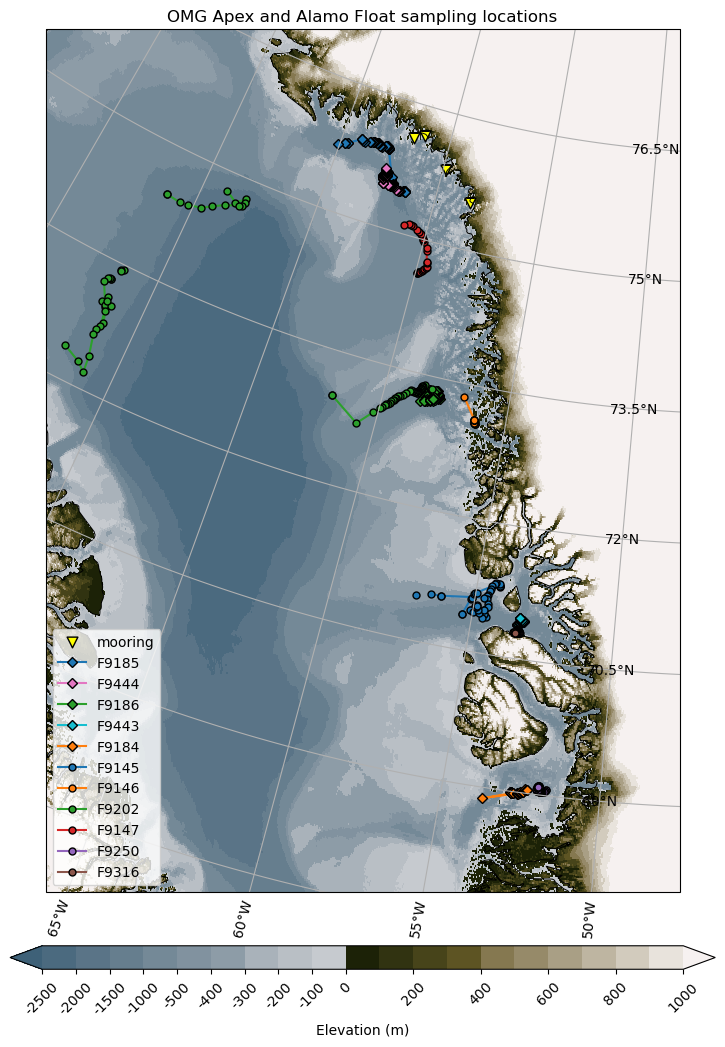

In [75]:
plt.figure(figsize=(13,14))
plt.rcParams['font.size'] = '10'

ax = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude = -45))
ax.set_extent([-67, -49, 68, 77], ccrs.PlateCarree())
# ax.set_extent([-64, -24, 58, 85], ccrs.PlateCarree())

# define top and bottom colormaps 
top        = cm.get_cmap(cmocean.cm.diff, 11)
bottom     = cm.get_cmap(cmocean.cm.diff_r, 12)
newcolors  = np.vstack((top(np.linspace(0.15, 0.4, 11)),
                       bottom(np.linspace(0, 0.5, 12)))) # create a new colormaps
ocean_land = ListedColormap(newcolors, name='ocean_land')
bounds     = [-2500,-2000,-1500,-1000,-500,-400,-300,-200,-100,0,100,200,300,400,500,600,700,800,900,1000]
ticks      = [-2500,-2000,-1500,-1000,-500,-400,-300,-200,-100,0,200,400,600,800,1000]

pc   = bathy_select.plot.pcolormesh('lon','lat',ax=ax,transform=ccrs.PlateCarree(),shading='auto',rasterized=True,cmap=ocean_land,levels=bounds,add_colorbar=False)
cbar = plt.colorbar(pc, label='Elevation (m)',ticks=ticks,boundaries=bounds,orientation='horizontal',shrink=0.7,spacing='uniform',pad=0.05,aspect=30)
cbar.ax.set_xticklabels(ticks,rotation=45)

ax.coastlines(linewidths=0.7)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl.top_labels = False
gl.left_labels = True
gl.right_labels = True

# add markers for mooring loccations
ax.scatter(-58.410533, 75.5413, s=60, c='yellow',edgecolor='black',marker="v",transform=ccrs.PlateCarree(), label='mooring')
ax.scatter(-59.8429, 75.843683, s=60, c='yellow',edgecolor='black',marker="v",transform=ccrs.PlateCarree()) 
ax.scatter(-61.279117, 76.160533, s=60, c='yellow',edgecolor='black',marker="v",transform=ccrs.PlateCarree())
ax.scatter(-61.726983, 76.103817, s=60, c='yellow',edgecolor='black',marker="v",transform=ccrs.PlateCarree()) 

# add apex float coordinates
ax.plot(F9185_data_ds.lon,F9185_data_ds.lat,'-D', color='tab:blue', markersize=5, markeredgecolor='k', transform=ccrs.PlateCarree(), label="F9185")
ax.plot(F9444_data_ds.lon,F9444_data_ds.lat,'-D', color='tab:pink', markersize=5, markeredgecolor='k', transform=ccrs.PlateCarree(), label="F9444")
ax.plot(F9186_data_ds.lon,F9186_data_ds.lat,'-D', color='tab:green', markersize=5, markeredgecolor='k', transform=ccrs.PlateCarree(), label="F9186")
ax.plot(F9443_data_ds.lon,F9443_data_ds.lat,'-D', color='tab:cyan', markersize=5, markeredgecolor='k', transform=ccrs.PlateCarree(), label="F9443")
ax.plot(F9184_data_ds.lon,F9184_data_ds.lat,'-D', color='tab:orange', markersize=5, markeredgecolor='k', transform=ccrs.PlateCarree(), label="F9184")

# add alamo float coordinates
ax.plot(F9145_data_ds.lon,F9145_data_ds.lat,'-o', markersize=5, markeredgecolor='k', transform=ccrs.PlateCarree(), label="F9145")
ax.plot(F9146_data_ds.lon,F9146_data_ds.lat,'-o', markersize=5, markeredgecolor='k', transform=ccrs.PlateCarree(), label="F9146")
ax.plot(F9202_data_ds.lon,F9202_data_ds.lat,'-o', markersize=5, markeredgecolor='k', transform=ccrs.PlateCarree(), label="F9202")
ax.plot(F9147_data_ds.lon,F9147_data_ds.lat,'-o', markersize=5, markeredgecolor='k', transform=ccrs.PlateCarree(), label="F9147")
ax.plot(F9250_data_ds.lon,F9250_data_ds.lat,'-o', markersize=5, markeredgecolor='k', transform=ccrs.PlateCarree(), label="F9250")
# ax.plot(F9275_data_ds.lon,F9275_data_ds.lat,'-o', markersize=5, markeredgecolor='k', transform=ccrs.PlateCarree(), label="F9275")
# ax.plot(F9312_data_ds.lon,F9312_data_ds.lat,'-o', markersize=5, markeredgecolor='k', transform=ccrs.PlateCarree(), label="F9312")
# ax.plot(F9315_data_ds.lon,F9315_data_ds.lat,'-o', markersize=5, markeredgecolor='k', transform=ccrs.PlateCarree(), label="F9315")
ax.plot(F9316_data_ds.lon,F9316_data_ds.lat,'-o', markersize=5, markeredgecolor='k', transform=ccrs.PlateCarree(), label="F9316")

ax.legend(loc='lower left')

plt.title("OMG Apex and Alamo Float sampling locations");

plt.savefig("figures/maps/Float_locations_BB_map.png", bbox_inches='tight', dpi=300, facecolor='white')

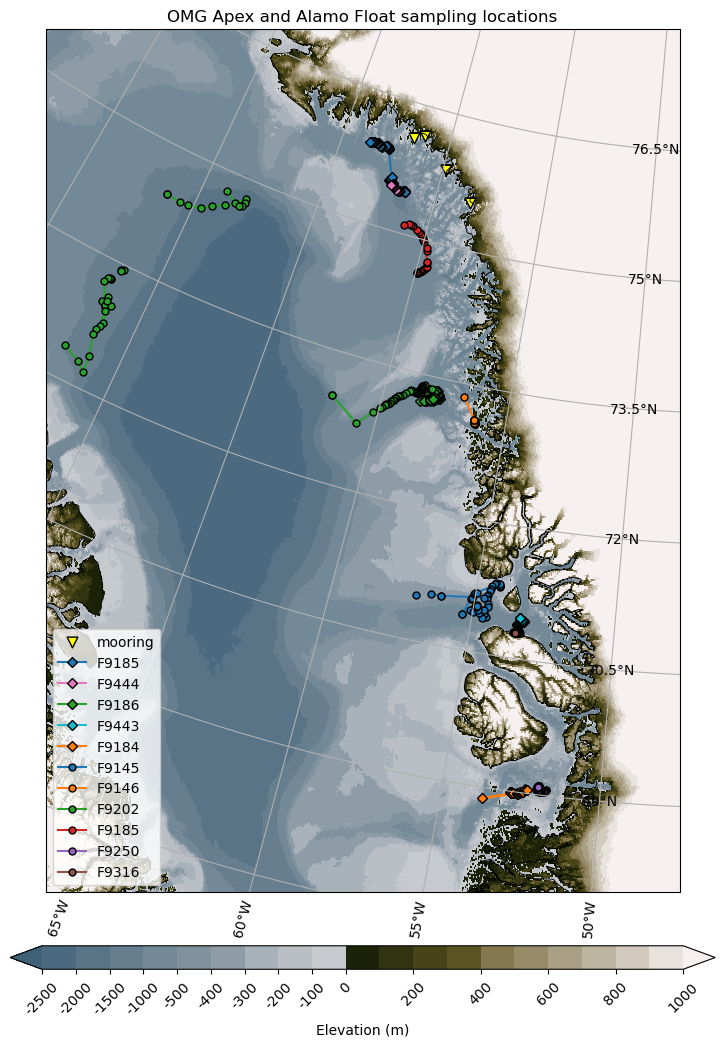

In [43]:
plt.figure(figsize=(13,14))
plt.rcParams['font.size'] = '10'

ax = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude = -45))
ax.set_extent([-67, -49, 68, 77], ccrs.PlateCarree())
# ax.set_extent([-64, -24, 58, 85], ccrs.PlateCarree())

# define top and bottom colormaps 
top        = cm.get_cmap(cmocean.cm.diff, 11)
bottom     = cm.get_cmap(cmocean.cm.diff_r, 12)
newcolors  = np.vstack((top(np.linspace(0.15, 0.4, 11)),
                       bottom(np.linspace(0, 0.5, 12)))) # create a new colormaps
ocean_land = ListedColormap(newcolors, name='ocean_land')
bounds     = [-2500,-2000,-1500,-1000,-500,-400,-300,-200,-100,0,100,200,300,400,500,600,700,800,900,1000]
ticks      = [-2500,-2000,-1500,-1000,-500,-400,-300,-200,-100,0,200,400,600,800,1000]

pc   = bathy_select.plot.pcolormesh('lon','lat',ax=ax,transform=ccrs.PlateCarree(),shading='auto',rasterized=True,cmap=ocean_land,levels=bounds,add_colorbar=False)
cbar = plt.colorbar(pc, label='Elevation (m)',ticks=ticks,boundaries=bounds,orientation='horizontal',shrink=0.7,spacing='uniform',pad=0.05,aspect=30)
cbar.ax.set_xticklabels(ticks,rotation=45)

ax.coastlines(linewidths=0.7)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl.top_labels = False
gl.left_labels = True
gl.right_labels = True

# add markers for mooring loccations
ax.scatter(-58.410533, 75.5413, s=60, c='yellow',edgecolor='black',marker="v",transform=ccrs.PlateCarree(), label='mooring')
ax.scatter(-59.8429, 75.843683, s=60, c='yellow',edgecolor='black',marker="v",transform=ccrs.PlateCarree()) 
ax.scatter(-61.279117, 76.160533, s=60, c='yellow',edgecolor='black',marker="v",transform=ccrs.PlateCarree())
ax.scatter(-61.726983, 76.103817, s=60, c='yellow',edgecolor='black',marker="v",transform=ccrs.PlateCarree()) 

# add apex float coordinates
ax.plot(F9185_data_ds.lon,F9185_data_ds.lat,'-D', color='tab:blue', markersize=5, markeredgecolor='k', transform=ccrs.PlateCarree(), label="F9185")
ax.plot(F9444_data_ds.lon,F9444_data_ds.lat,'-D', color='tab:pink', markersize=5, markeredgecolor='k', transform=ccrs.PlateCarree(), label="F9444")
ax.plot(F9186_data_ds.lon,F9186_data_ds.lat,'-D', color='tab:green', markersize=5, markeredgecolor='k', transform=ccrs.PlateCarree(), label="F9186")
ax.plot(F9443_data_ds.lon,F9443_data_ds.lat,'-D', color='tab:cyan', markersize=5, markeredgecolor='k', transform=ccrs.PlateCarree(), label="F9443")
ax.plot(F9184_data_ds.lon,F9184_data_ds.lat,'-D', color='tab:orange', markersize=5, markeredgecolor='k', transform=ccrs.PlateCarree(), label="F9184")

# add alamo float coordinates
ax.plot(F9145_data_ds.lon,F9145_data_ds.lat,'-o', markersize=5, markeredgecolor='k', transform=ccrs.PlateCarree(), label="F9145")
ax.plot(F9146_data_ds.lon,F9146_data_ds.lat,'-o', markersize=5, markeredgecolor='k', transform=ccrs.PlateCarree(), label="F9146")
ax.plot(F9202_data_ds.lon,F9202_data_ds.lat,'-o', markersize=5, markeredgecolor='k', transform=ccrs.PlateCarree(), label="F9202")
ax.plot(F9147_data_ds.lon,F9147_data_ds.lat,'-o', markersize=5, markeredgecolor='k', transform=ccrs.PlateCarree(), label="F9185")
ax.plot(F9250_data_ds.lon,F9250_data_ds.lat,'-o', markersize=5, markeredgecolor='k', transform=ccrs.PlateCarree(), label="F9250")
# ax.plot(F9275_data_ds.lon,F9275_data_ds.lat,'-o', markersize=5, markeredgecolor='k', transform=ccrs.PlateCarree(), label="F9275")
# ax.plot(F9312_data_ds.lon,F9312_data_ds.lat,'-o', markersize=5, markeredgecolor='k', transform=ccrs.PlateCarree(), label="F9312")
# ax.plot(F9315_data_ds.lon,F9315_data_ds.lat,'-o', markersize=5, markeredgecolor='k', transform=ccrs.PlateCarree(), label="F9315")
ax.plot(F9316_data_ds.lon,F9316_data_ds.lat,'-o', markersize=5, markeredgecolor='k', transform=ccrs.PlateCarree(), label="F9316")

ax.legend(loc='lower left')

plt.title("OMG Apex and Alamo Float sampling locations");

plt.savefig("figures/maps/Float_locations_BB_map.png", bbox_inches='tight', dpi=300, facecolor='white')